## 高糖预测项目实验报告

# 学生信息
        
*  学号：19220423
*  姓名：李世博
*  专业：人工智能
*  班级：192204
*  小组：9

## 一、项目背景

### 1.1 项目背景
智能穿戴技术作为一种无创设备为解决糖尿病前期人群的控糖监测提供了便利。TIR、TAR、TBR是动态血糖监测系统的重要参数分别反映了血糖良好控制情况、高血糖和低血糖情况。针对不同的个体情况，应该个性化设定TIR、TAR和TBR。

### 1.2 项目目标 

本项目从穿戴设备记录的数据中提取特征，训练机器学习模型，测试人群一天内的不同阶段是否发生高糖，进而统计每天高糖的发生次数。

## 二、数据探索与预处理 

### 2.1 数据集介绍 

本项目包含一份血糖监测设备记录用户测量值数据集，由16个糖前（或者接近糖前）用户组成，血糖监测设备记录用户的葡萄糖浓度（mg/dl）,穿戴设备记录了血容量脉冲（BVP）信号、皮肤电活动（EDA）、皮肤温度（TEMP）、心率（HR）、搏动间隔（IBI）和三轴加速度计（ACC）。

每位用户的文件夹内均有8个csv文件，每个文件中存放着对应特征的记录时间与数值。其中Dexcom文件中保存的是通过血糖监测设备记录的用户真实血糖值，其余的七个csv文件中保存的均为通过穿戴设备记录的特征值，其中Food_Log表示用户饮食的数据，含文本特征，可单独考虑。


### 2.2 探索性数据分析 

> 要求：
（1）观察是否高糖的数据分布，画出柱状图，观察类别是否均衡，如果不均衡，是否会对我们构建的分类模型产生影响？ 请谈谈你的看法。
（2）请简要分析一下不同特征的取值范围和特点，以及对用户是否高糖的影响，画出如下柱状图，观察其内在关联。
（3）针对不同特征在时间序列上的特点，设计两种以上时序特征提取方法，并分析其有效性。
（4）文字内容不限于上述三点，可以根据自己的理解阐述更多内容。


#### 2.2.1 观察高糖数据分布


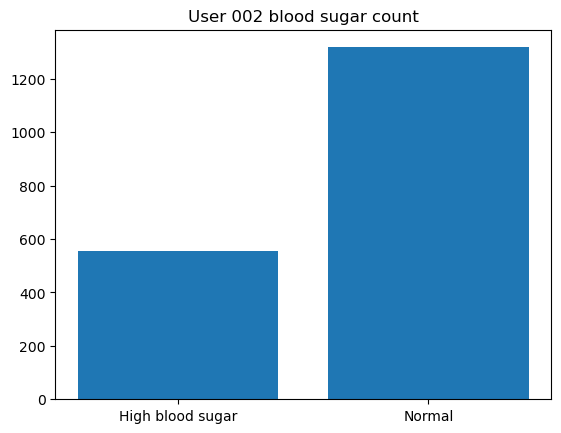

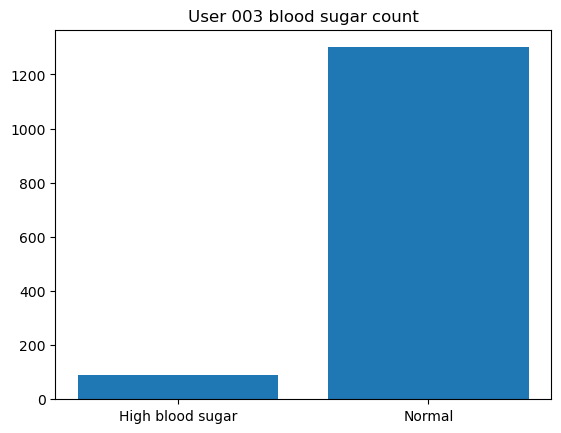

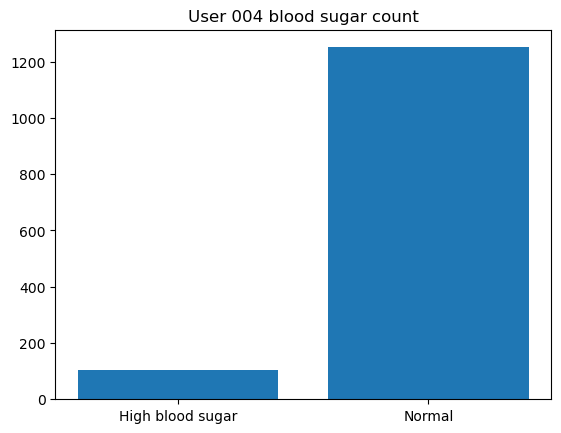

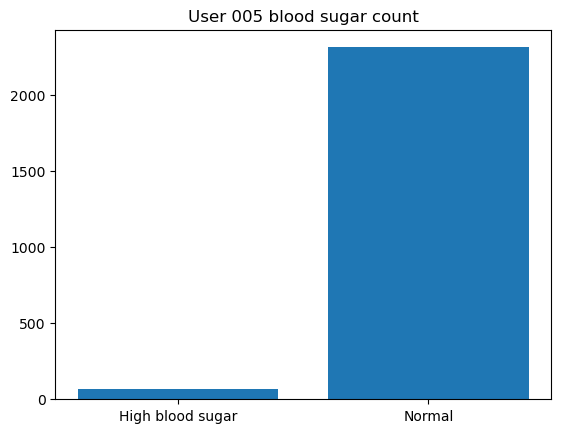

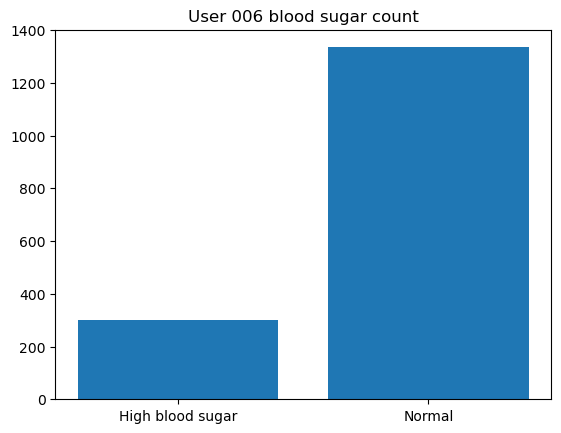

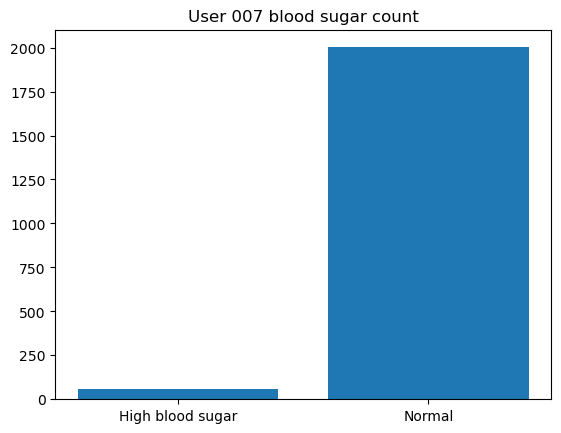

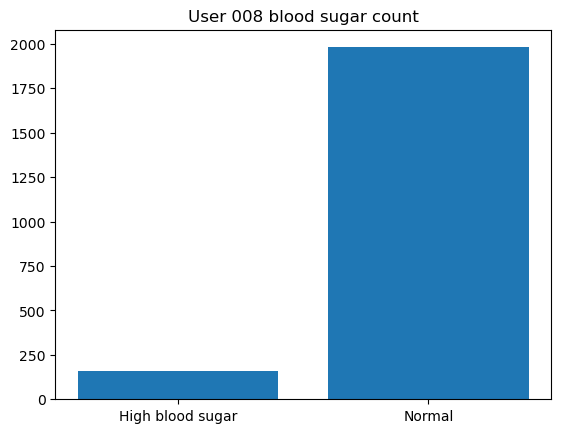

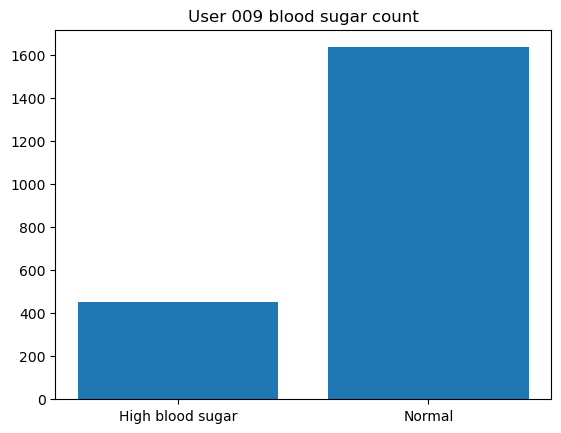

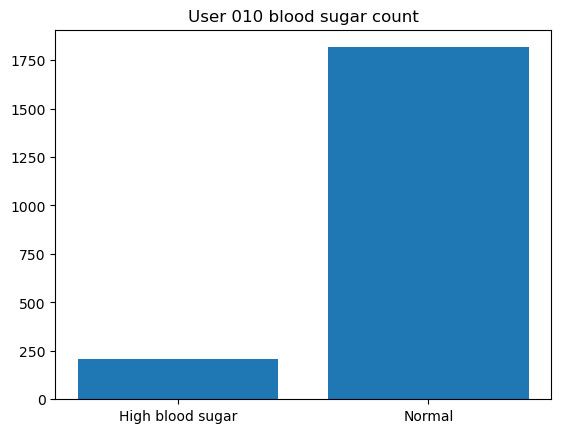

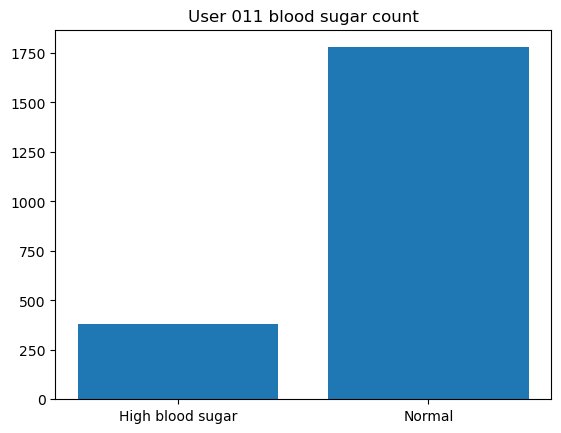

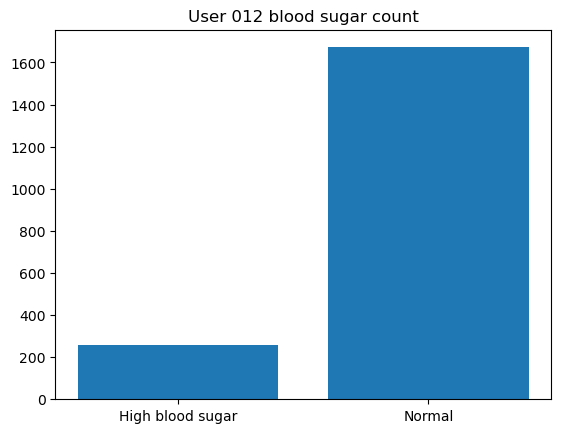

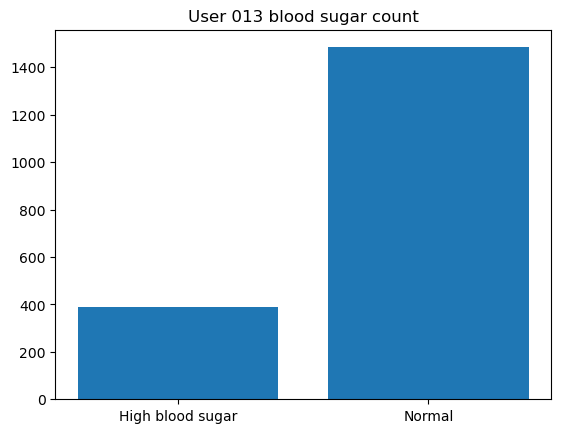

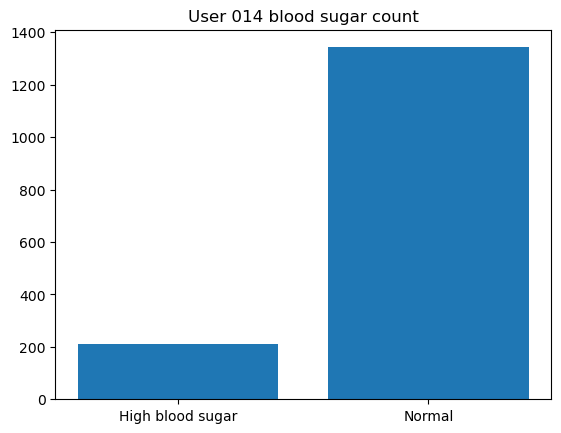

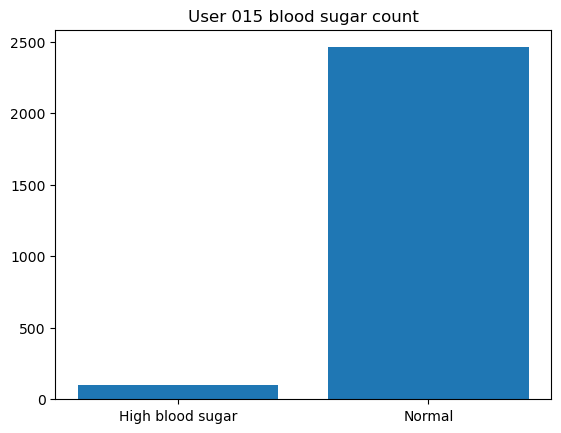

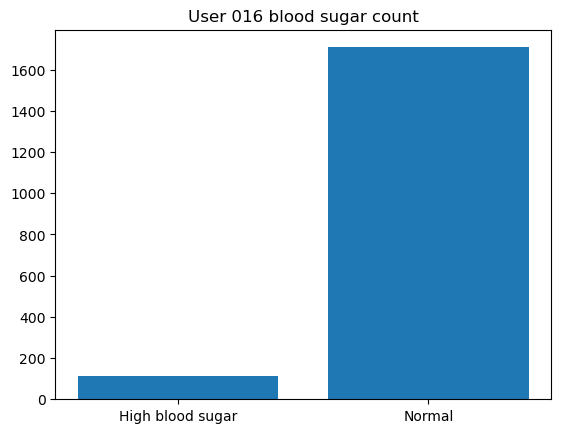

In [15]:
# 画出每一个用户的高血糖样本数与正常样本数的柱状图
import pandas as pd
import matplotlib.pyplot as plt
# 定义文件编号列表
file_nums = [f'{i:03d}' for i in range(2, 17)]  # 生成从 '002' 到 '016' 的文件编号

for file_num in file_nums:
    # 高血糖标准，>=140为高血糖
    high_blood_sugar = 140
    # 具体数据在processed_data文件夹下
    data = pd.read_csv(f'./processed_data/processed_data_{file_num}.csv')
    # 统计每个用户的高血糖样本数与正常样本数
    high_blood_sugar_count = data[data['Glucose Value (mg/dL)'] >= high_blood_sugar].shape[0]
    normal_count = data[data['Glucose Value (mg/dL)'] < high_blood_sugar].shape[0]
    # 画出柱状图
    plt.bar(['High blood sugar', 'Normal'], [high_blood_sugar_count, normal_count])
    plt.title(f'User {file_num} blood sugar count')
    plt.show()



由图可知，所有用户的高糖与正常类别都是不平衡的。
类别不平衡可能会导致以下几个问题：

1. **模型偏向**：模型可能会偏向于预测多数类，因为从统计学的角度来看，预测多数类可以得到更高的准确率。这会导致少数类的预测性能较差。

2. **评估指标失真**：使用如准确率（accuracy）这样的评估指标可能会误导人，因为它没有考虑到类别不平衡的影响。例如，即使模型总是预测多数类，也可能得到较高的准确率。

3. **过拟合少数类**：尝试纠正类别不平衡可能导致模型对少数类过拟合，从而牺牲了其在多数类上的表现。

4. **训练效率低下**：模型可能需要更长的时间来收敛，因为它需要学习如何正确地处理不平衡的样本分布。

为了解决类别不平衡问题，通常可以采取以下几种策略：

- **重采样技术**：包括上采样（增加少数类样本的数量）和下采样（减少多数类样本的数量）。也可以使用SMOTE等技术合成新的少数类样本。

- **成本敏感学习**：为不同的分类错误赋予不同的权重，使得模型在训练过程中更加重视少数类。

- **集成方法**：使用多个模型进行投票以提高预测的准确性，这可以帮助缓解类别不平衡带来的影响。

- **调整决策阈值**：对于概率预测模型，可以通过调整决策阈值来优化对少数类的预测。


#### 2.2.2不同特征与血糖的关系

这里，我们抽样002号用户的2020-02-22这天作为样本，观察这一天中，其各个特征数据与血糖变化的关系

C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3031747850.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data[column] = (day_data[column] - min_val) / (max_val - min_val)


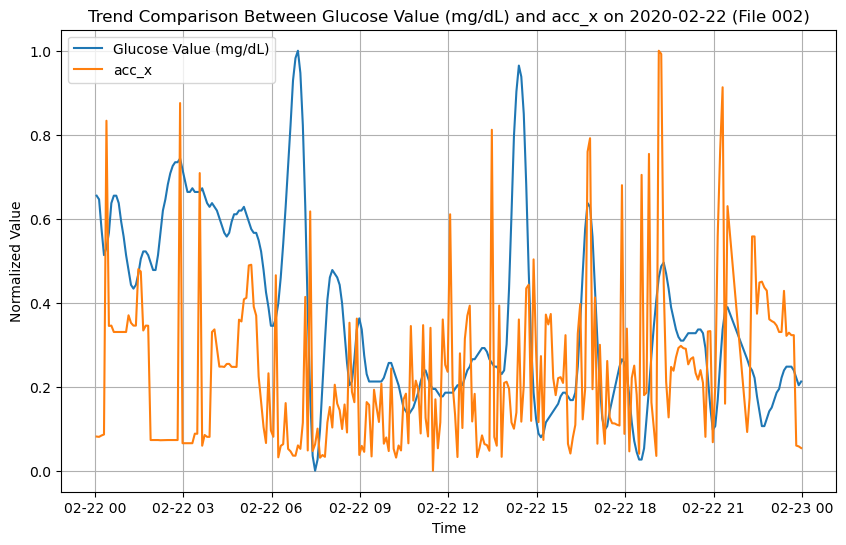

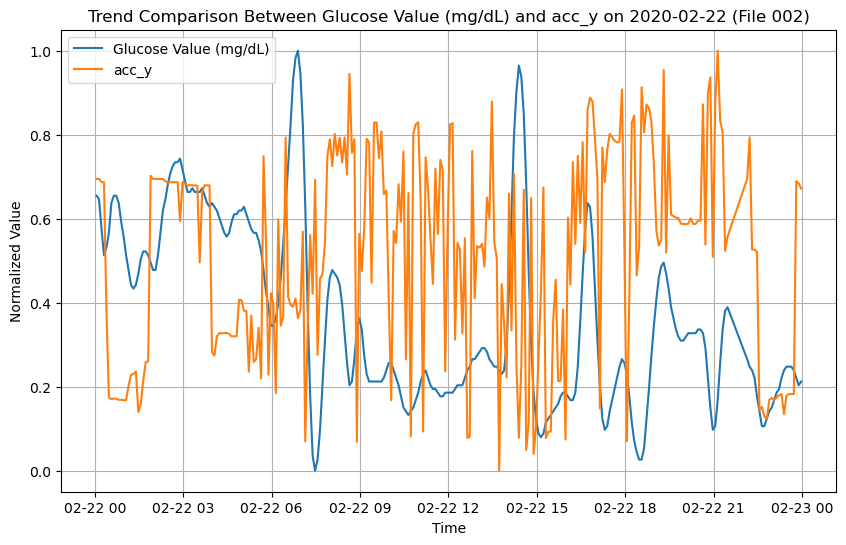

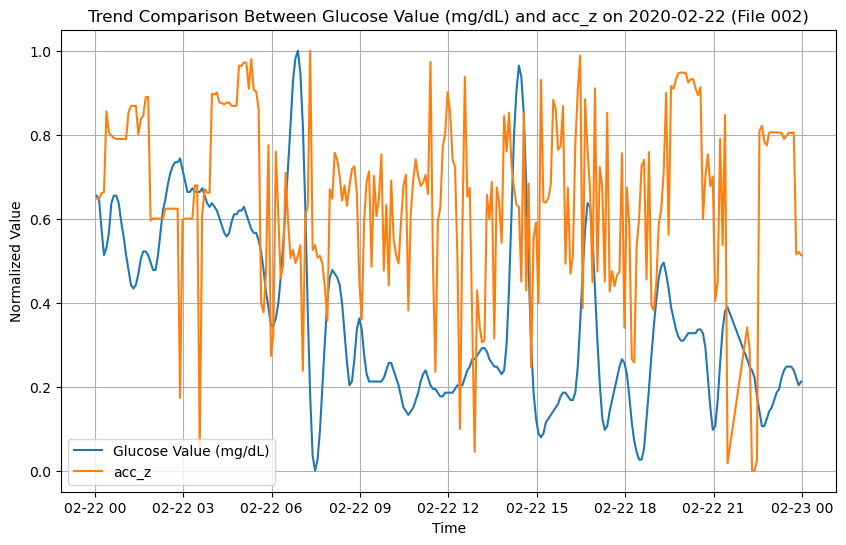

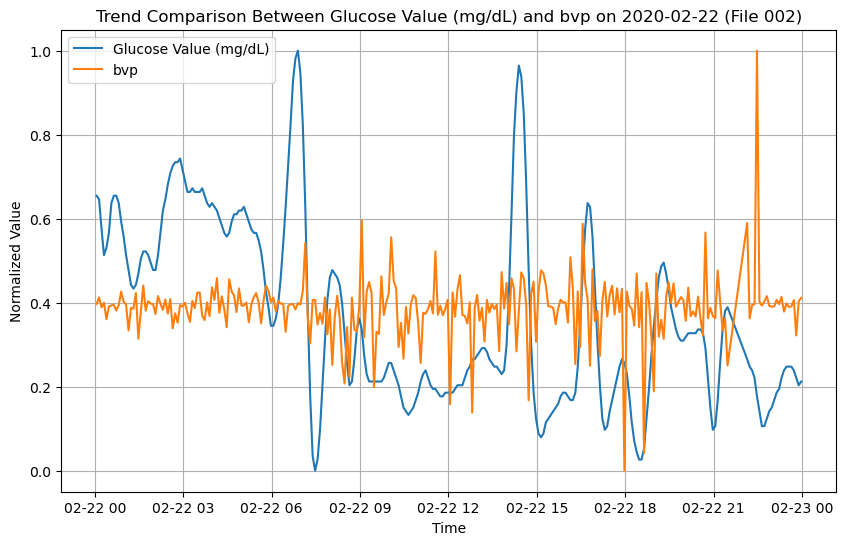

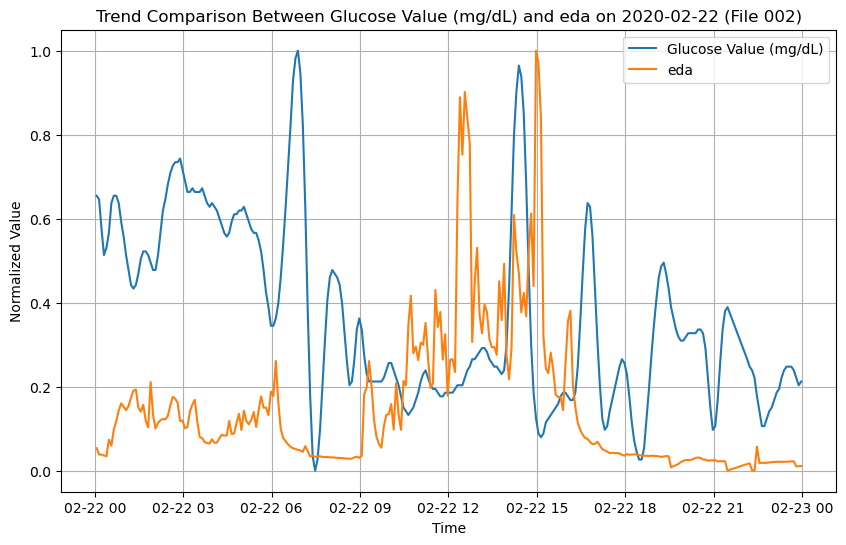

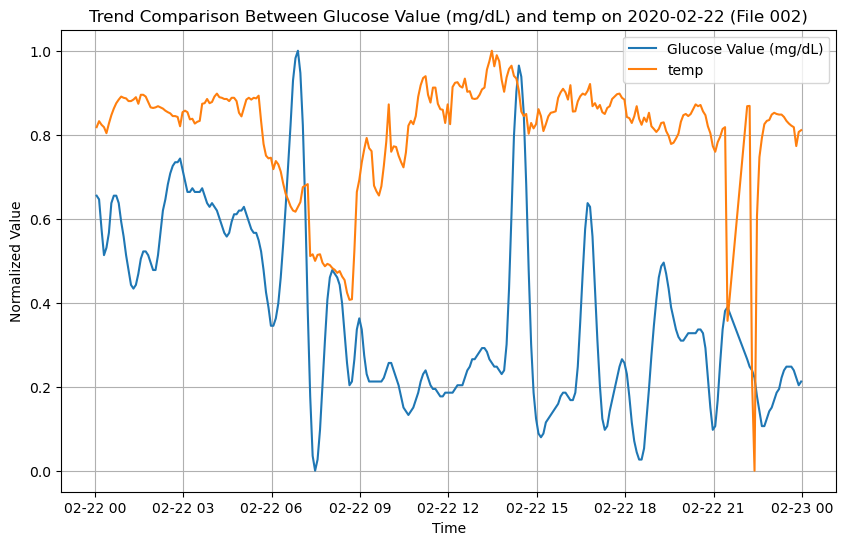

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 定义高糖阈值
gaotang = 140

# 指定要绘制的文件编号
file_num = '002'

# 指定要绘制的一天
target_date = '2020-02-22'

# 读取 CSV 文件
data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')

# 将第一列转换为 datetime 类型
data['datetime'] = pd.to_datetime(data.iloc[:, 0], errors='coerce')

# 过滤出目标日期的数据
day_data = data[data['datetime'].dt.date == pd.to_datetime(target_date).date()]

# 获取第二列（假设是数值类型）
second_column = day_data.columns[1]

# 检查第二列是否为数值类型
if not pd.api.types.is_numeric_dtype(day_data[second_column]):
    raise ValueError(f"The second column '{second_column}' is not numeric.")

# 对每一列进行归一化处理
for column in day_data.select_dtypes(include=['number']).columns:
    min_val = day_data[column].min()
    max_val = day_data[column].max()
    if max_val != min_val:  # 避免除以0的情况
        day_data[column] = (day_data[column] - min_val) / (max_val - min_val)
    else:
        # 如果最大值等于最小值，意味着该列所有的值都是相同的，可以设置为0或1
        day_data[column] = 0  # 或者选择其他合适的值

# 获取所有非时间列
feature_columns = day_data.columns[1:8]

# 对于每一个特征列创建一个新的图形
for i, col in enumerate(feature_columns):
    if col != second_column and pd.api.types.is_numeric_dtype(day_data[col]):
        plt.figure(figsize=(10, 6))
        plt.plot(day_data['datetime'], day_data[second_column], label=second_column)
        plt.plot(day_data['datetime'], day_data[col], label=col)
        
        plt.title(f'Trend Comparison Between {second_column} and {col} on {target_date} (File {file_num})')
        plt.xlabel('Time')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.grid(True)
        
        # 显示图形
        plt.show()

我们抽样002样本的其中一天，其各个特征与血糖值的时序图。试图找出不同特征的时序特征与血糖的时序特征的关系
- 关于acc，其有明显的白天高，夜晚低的趋势。且波动较大。这是由于白天活动较多，晚上活动较少。思路：可以检测运动，如果是有氧运动则血糖应该有下降趋势，如果是无氧运动应该血糖会有上升趋势
- 关于bvp，由图，bvp即血容量在一天中十分稳定，只有在部分时间出现了剧烈波动，与其对应的是血糖最低点。猜测bvp的波动与血糖过低有关，或者仅仅只是异常值，可以通过其他数据验证。
- 关于eda，eda为皮肤电刺激信号，通常与人的压力水平有关。而压力高导致的皮质醇浓度升高会导致血糖升高。由图中可以看出，其与血糖有一定的同峰情况，可以检测eda的高低来辅助推断血糖高低。
- 关于temp,对于002样本，在早上和入睡时降低明显。但可能是个人体质不一，需要验证。
- 关于hr和ibi,整体呈负相关，hr在白天高，晚上较低，ibi则相反。

#### 2.2.3 时序特征提取方法

针对时间序列数据的特点，可以设计多种时序特征提取方法来捕捉数据中的不同特性。以下是两种常见的时序特征提取方法及其有效性分析：

##### 1. 滑动窗口统计特征
滑动窗口统计特征是一种常用的方法，它通过在时间序列上滑动一个固定长度的窗口，并计算窗口内的统计数据。这种方法可以捕捉数据的局部特性。

##### 方法描述：
- **滑动窗口长度**：选择一个合适的窗口长度（这里选用一个小时），并在此窗口内进行统计计算。
- **统计量**：计算窗口内的平均值、标准差、最大值、最小值等统计量。
- **步长**：设定一个窗口移动的步长（这里每五分钟移动一次）。

##### 有效性分析：
- **优点**：
  - **局部特性捕捉**：能够捕捉数据在短时间内的变化趋势。
  - **异常检测**：通过观察统计量的变化，可以更容易地识别出异常情况。
  - **平滑噪声**：平均值等统计量有助于平滑噪声，提高信号质量。
- **缺点**：
  - **窗口长度选择**：窗口长度的选择会影响结果，需要根据具体应用场景进行调优。
  - **计算复杂度**：对于大数据集，滑动窗口计算可能会比较耗时。

##### 2. 频域特征
频域特征是通过对时间序列数据进行傅里叶变换（FFT）来提取的。这种方法可以捕捉数据的周期性和频率成分。

##### 方法描述：
- **傅里叶变换**：对时间序列数据进行快速傅里叶变换（FFT），得到频谱。
- **频谱特征**：提取频谱中的峰值频率、功率谱密度等特征。
- **倒谱分析**：对频谱进行再次变换，提取倒谱特征。

##### 有效性分析：
- **优点**：
  - **周期性检测**：能够有效地检测数据中的周期性成分。
  - **频率信息**：提供关于数据频率特性的信息，有助于理解数据的内在结构。
  - **降噪**：通过去除高频噪声，可以提高信号的质量。
- **缺点**：
  - **解释难度**：频域特征可能较难直接解释，需要专业知识来理解和分析。
  - **计算复杂度**：FFT计算复杂度较高，特别是对于长序列数据。

##### 总结
通过滑动窗口统计特征和频域特征提取方法，我们可以从不同的角度捕捉时间序列数据的特性。滑动窗口统计特征适合捕捉局部趋势和异常检测，而频域特征则适用于周期性检测和频率成分分析。结合这两种方法，可以更全面地理解和分析时间序列数据。

滑动窗口形成的数据在window_data文件夹中，其中是以一小时为窗口时长，5分钟为步长的数据。包含了平均值，标准差，增量，最大值，最小值，频谱特征，一小时内卡路里摄入量，糖分摄入量等特征。具体如下：end_time,acc_x_mean,acc_x_std,acc_x_max,acc_x_min,acc_x_delta,acc_x_peak_freq,acc_y_mean,acc_y_std,acc_y_max,acc_y_min,acc_y_delta,acc_y_peak_freq,acc_z_mean,acc_z_std,acc_z_max,acc_z_min,acc_z_delta,acc_z_peak_freq,bvp_mean,bvp_std,bvp_max,bvp_min,bvp_delta,bvp_peak_freq,eda_mean,eda_std,eda_max,eda_min,eda_delta,eda_peak_freq,temp_mean,temp_std,temp_max,temp_min,temp_delta,temp_peak_freq,ibi_mean,ibi_std,ibi_max,ibi_min,ibi_delta,ibi_peak_freq,calorie_sum,total_carb_sum,sugar_sum,protein_sum

目标变量为一小时内的高糖次数glucose_freq

通过sklearnSelectKBest最终选出最优特征如下：
           Feature      Score
26         eda_max  57.209430
25         eda_std  56.201907
24        eda_mean  39.570719
44       sugar_sum  33.367093
0       acc_x_mean  29.387410
3        acc_x_min  29.065137
43  total_carb_sum  28.688958
12      acc_z_mean  27.616566

### 2.3 数据预处理 

> 要求：
（1）请简要分析一下字段缺失值的分布情况，你分别对哪些字段进行了哪些处理？有没有异常？文字介绍具体方法，并展示前后变化。
（2）请简要分析连续型特征中异常值的分布情况，结合当前任务，在项目中你分别进行了怎样的处理？
（3）请简要分析哪些特征之间是相关的？结合当前任务，在项目中你分别进行了怎样的处理？
（4）文字内容不限于上述三点，可以根据自己的理解阐述更多内容。
        

#### 2.3.1 缺失值分布与处理
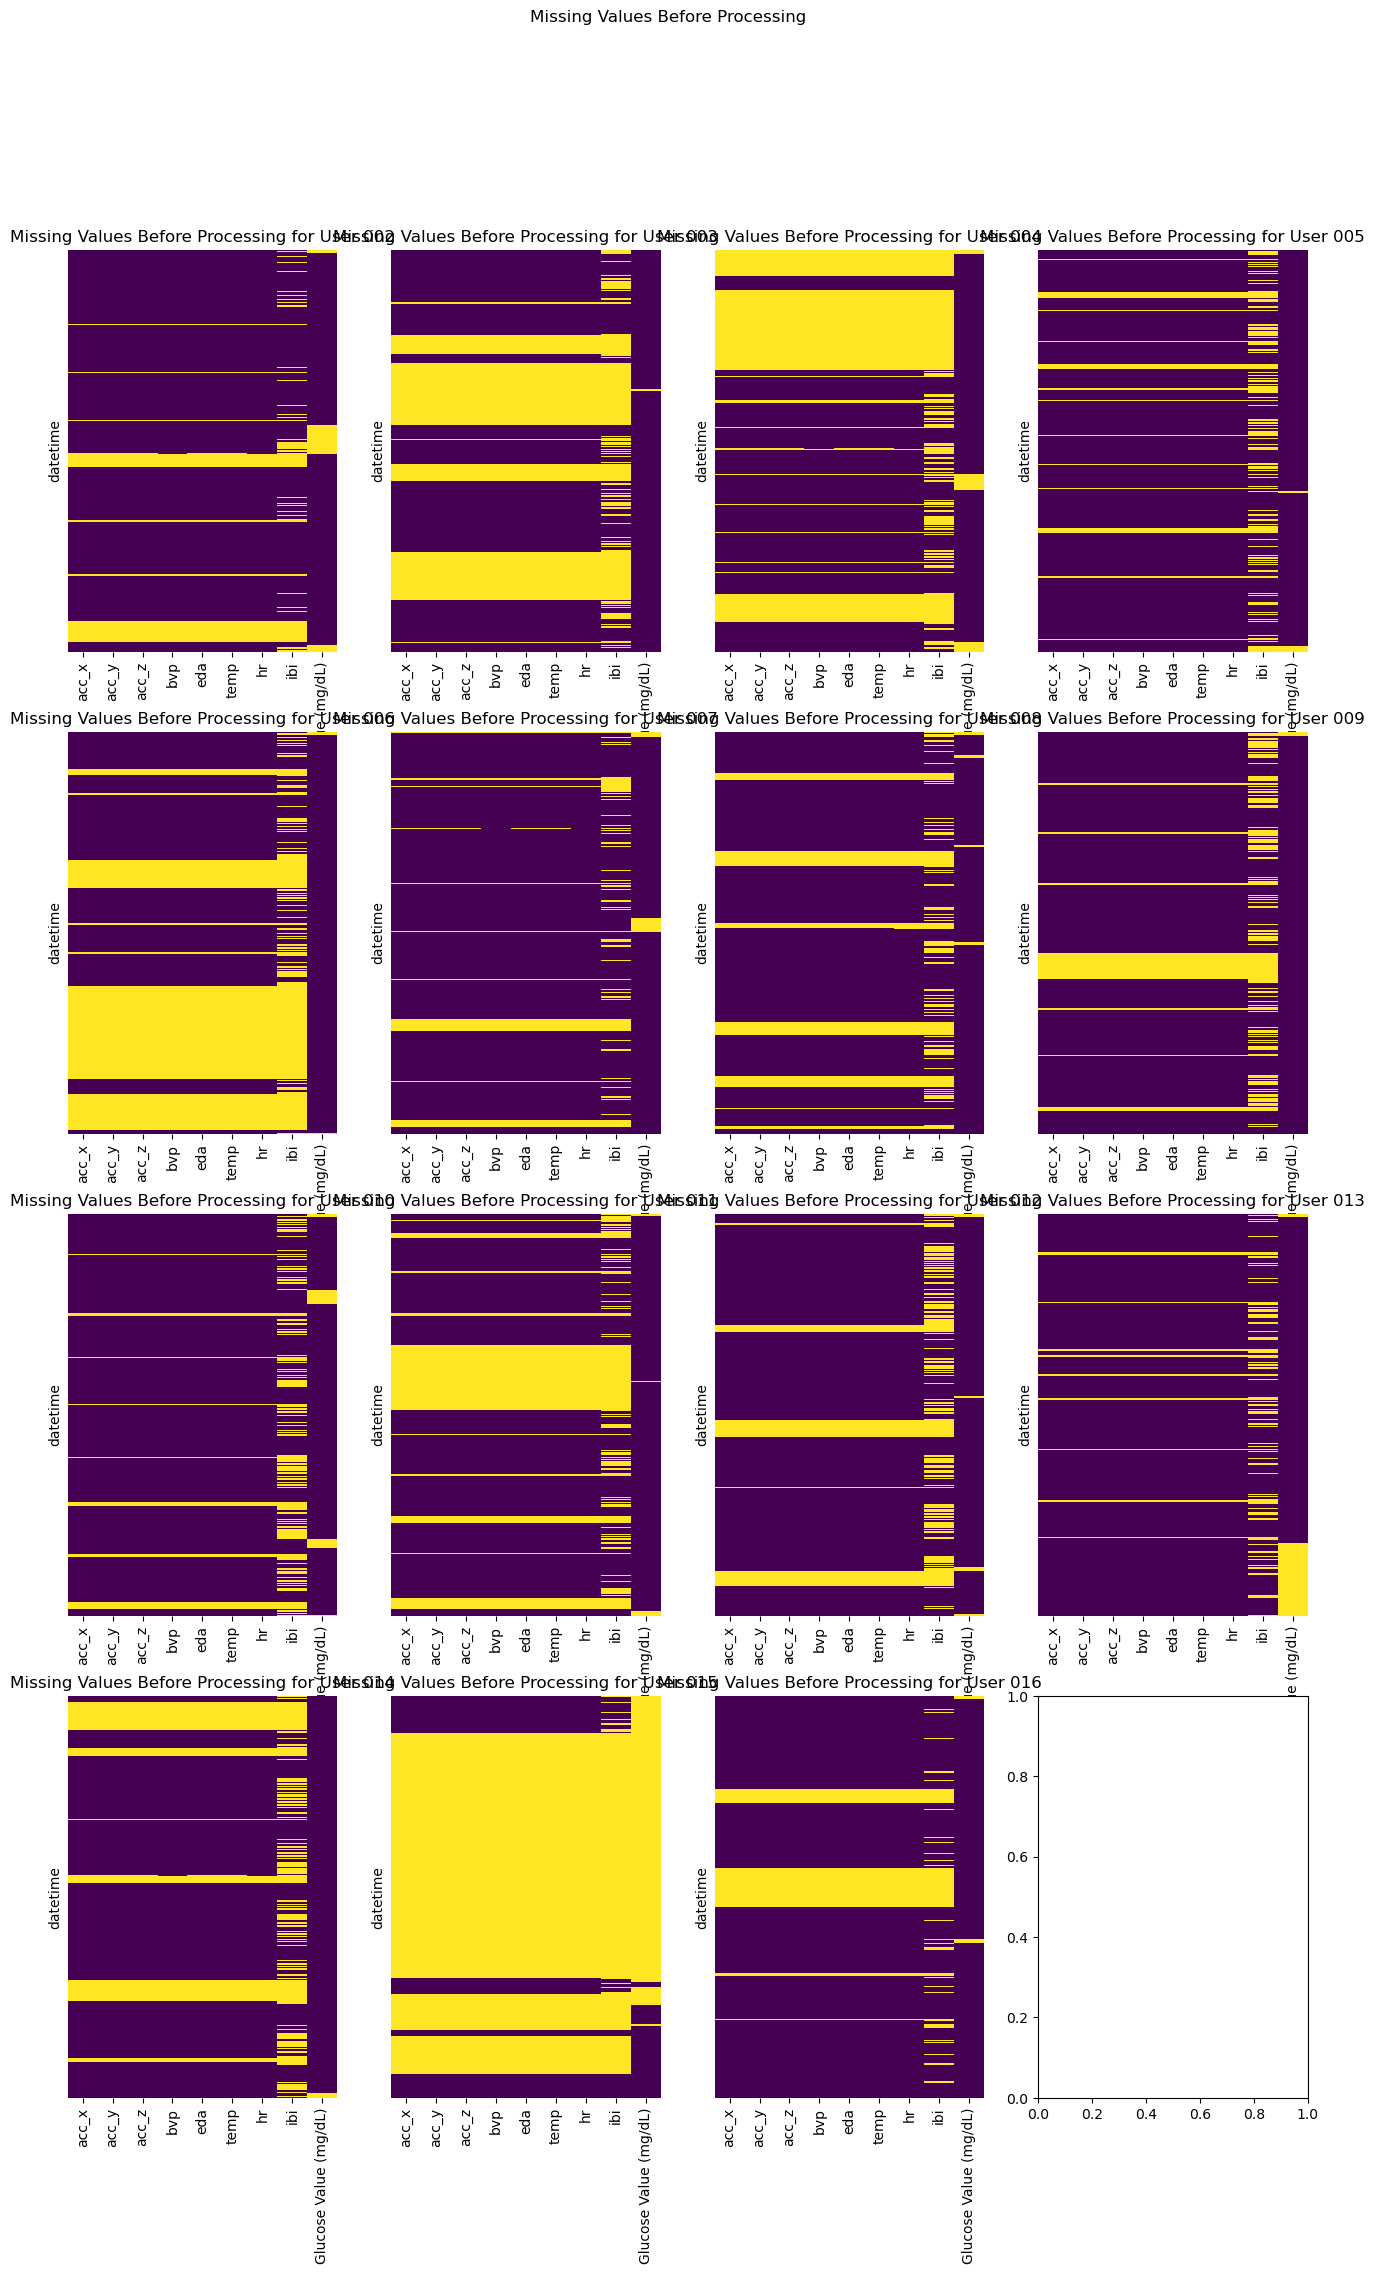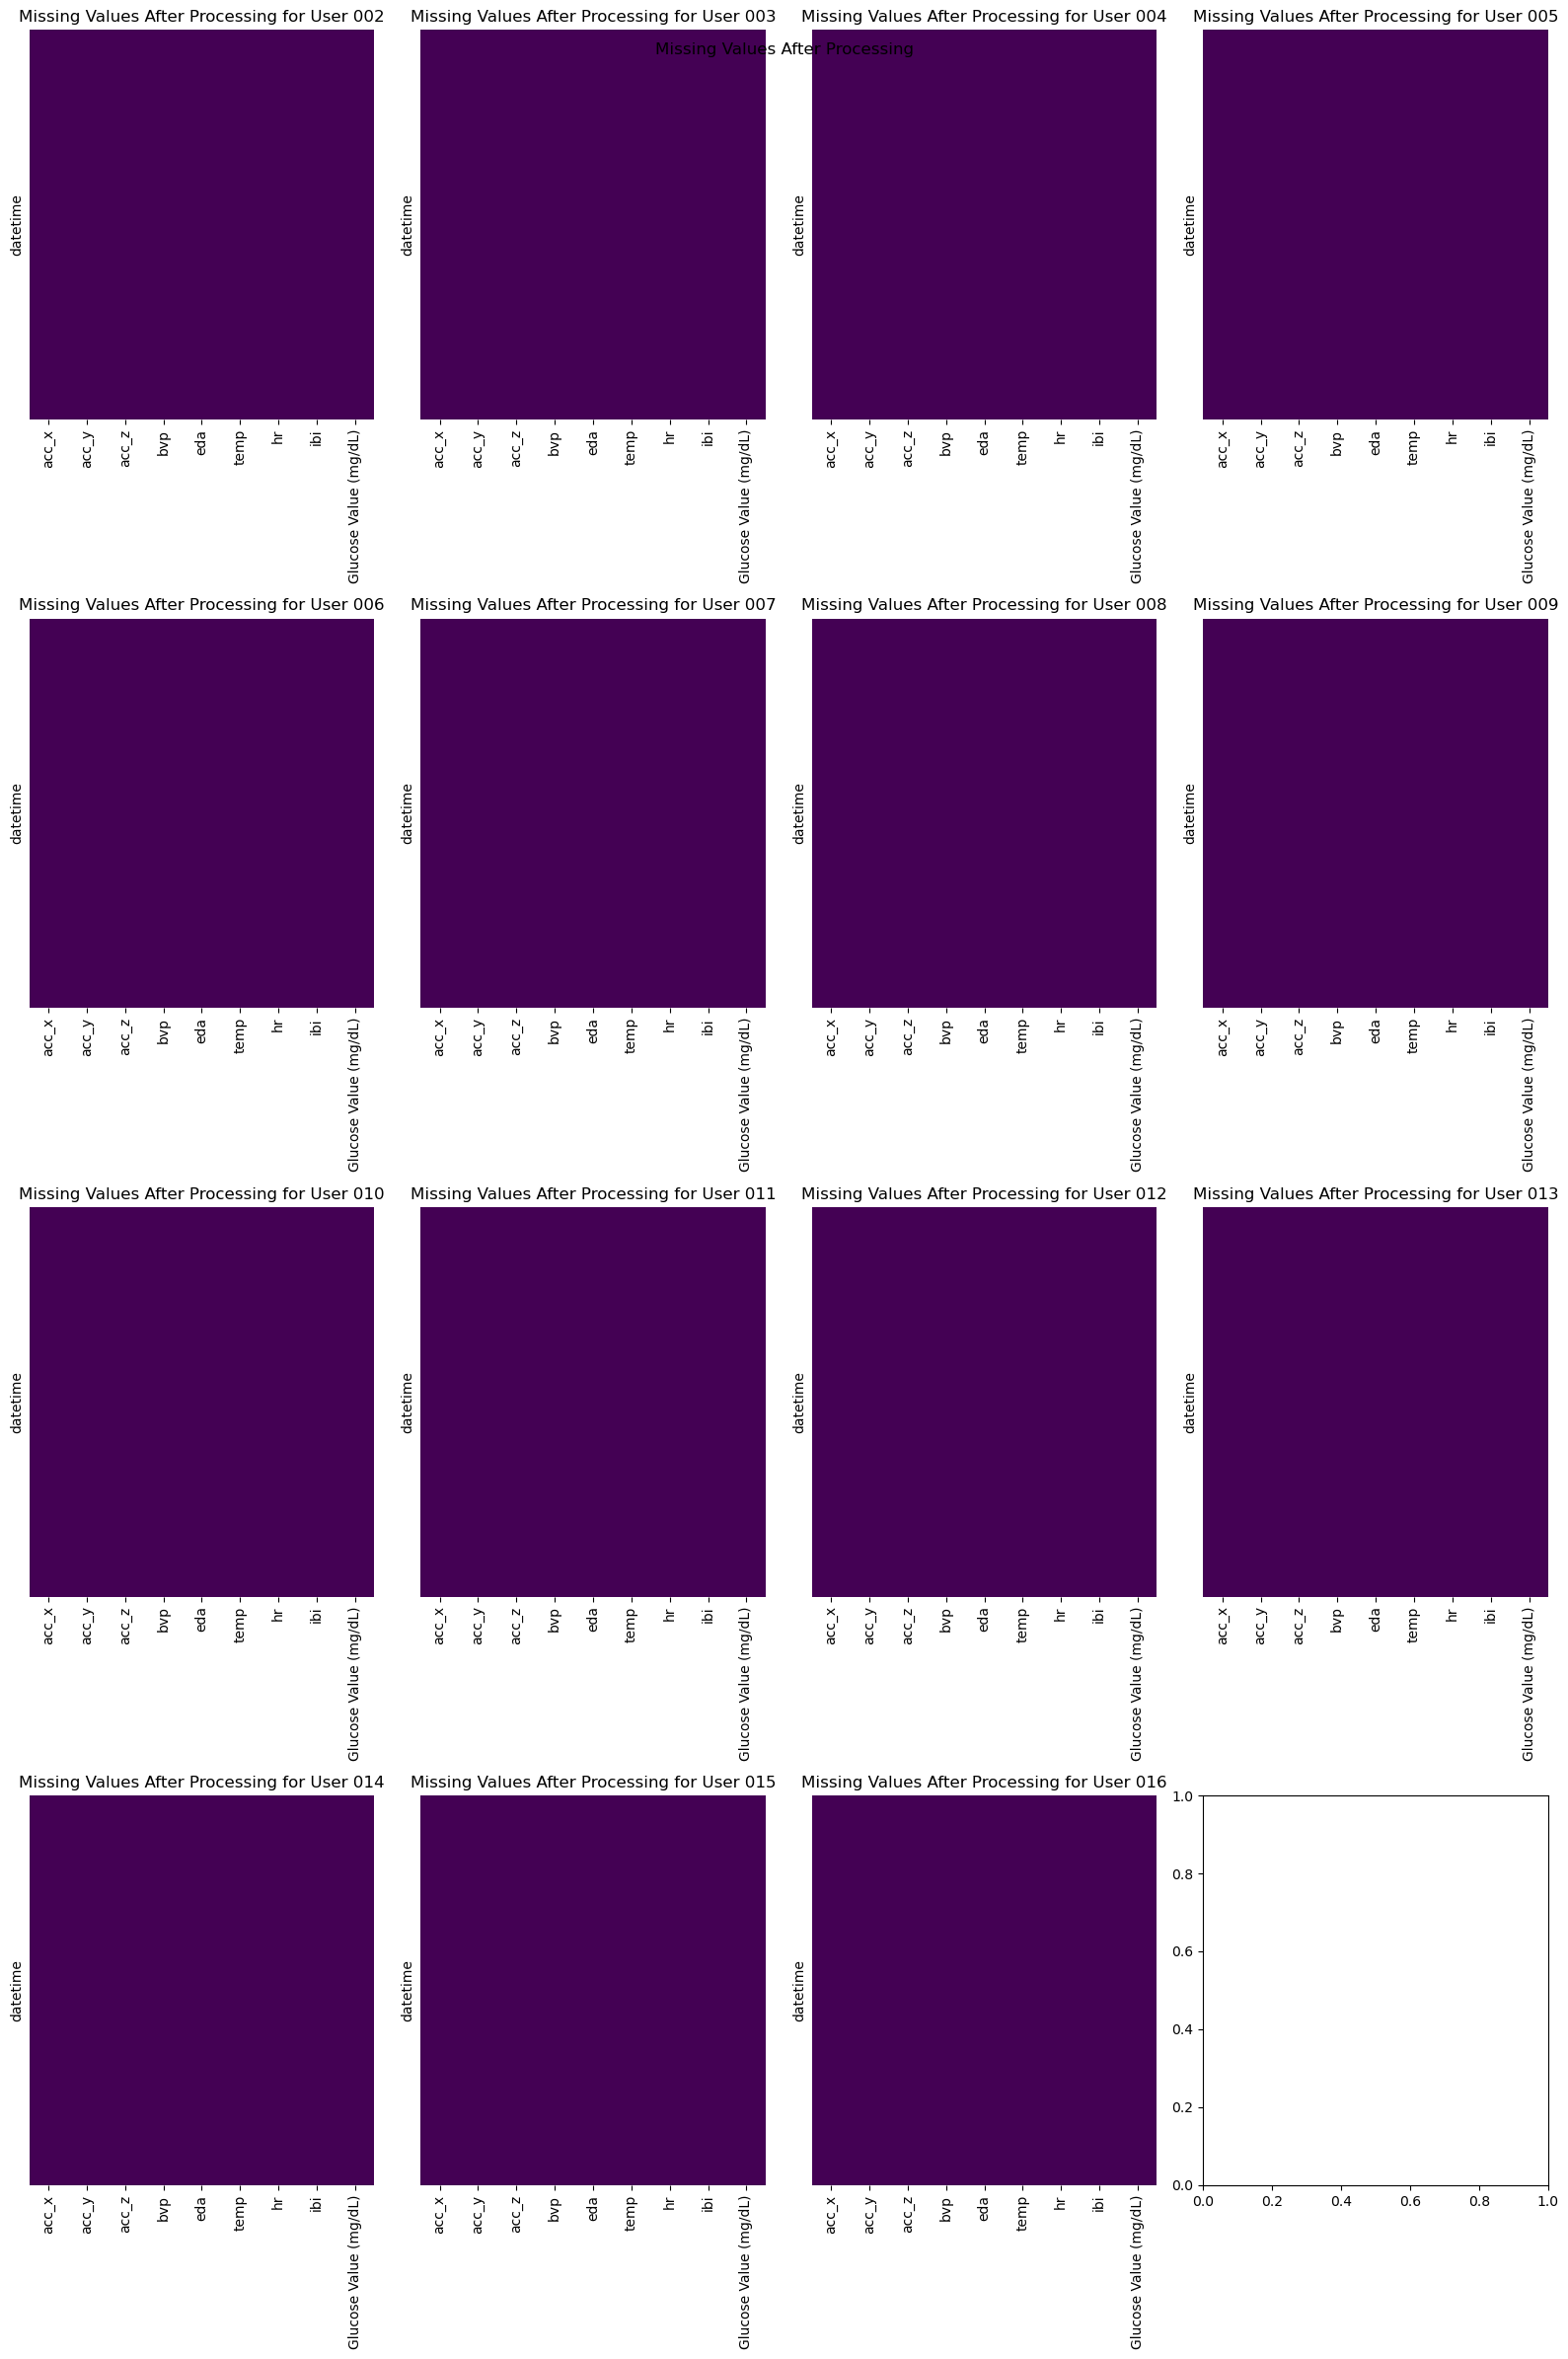

由图可知，一分钟数据缺失较多，使用五分钟间隔后缺失值明显减少，只对前后有数据的缺失值进行线性插值，其他则删除。

#### 2.3.2 异常值处理
由于本数据集为真实数据，噪声较大，且数据波动较大，异常值判断较为困难。所以对异常值采取保守态度，没有专门对异常值进行特殊处理。

#### 2.3.3 特征相关性
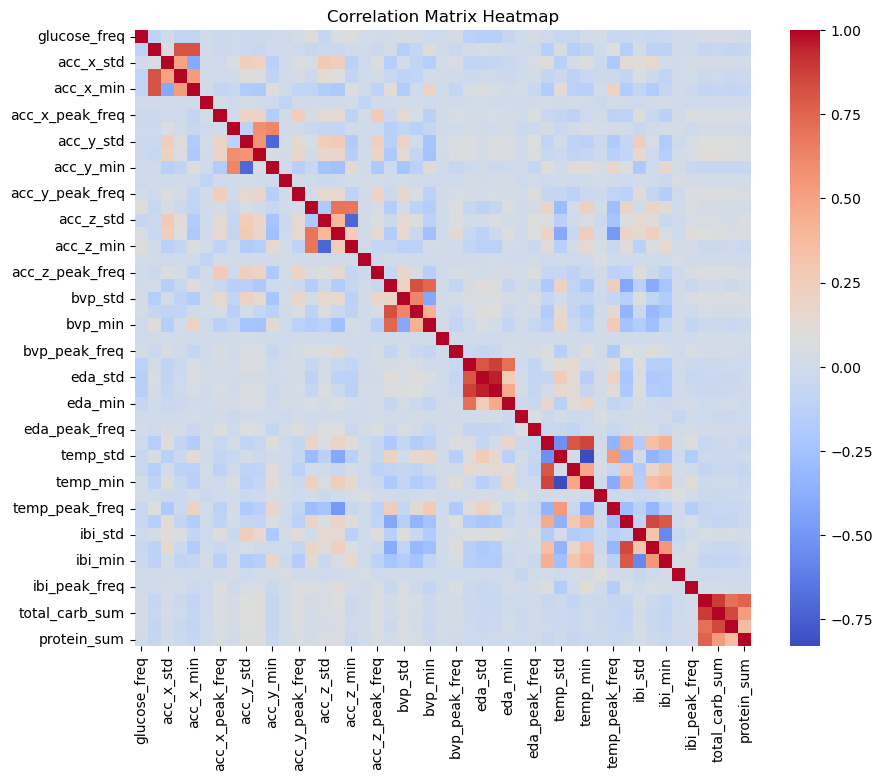

由相关性热力图可以看出，不同特征间除ibi与temp并无明显相关性，大部分构造的特征之间具有强相关。

## 三、高糖预测模型的构建与效果评估

### 3.1 高糖分类模型的构建与模型比较 
> 要求：文字描述该过程，包括数据划分、模型构建、参数调优、评价指标统计、模型比较，可视化展示结果并进行分析。

#### 3.1.1数据划分
对于数据划分，选取两个用户为测试集，其他为训练集。由于最后两个用户数据缺失较多，这里选用9,11号用户作为测试集
#### 3.1.2模型构建
模型选用了逻辑回归，SVM,随机森林,效果不好。增加GBDT,XGBoost模型
#### 3.1.3参数调优
对不同模型进行网格搜索调参，参数范围如下：
```
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'C': [0.001, 0.01], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    'Support Vector Machine': {
        'model': SVC(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
    }
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    }
}

```

#### 3.1.4 评价指标与模型比较

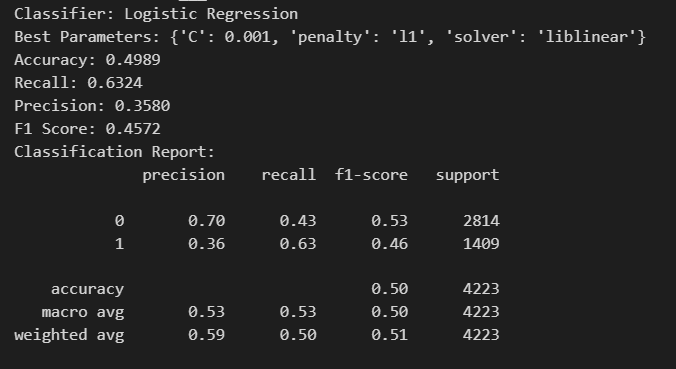
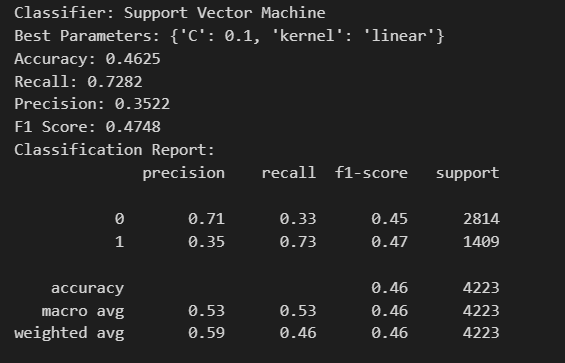
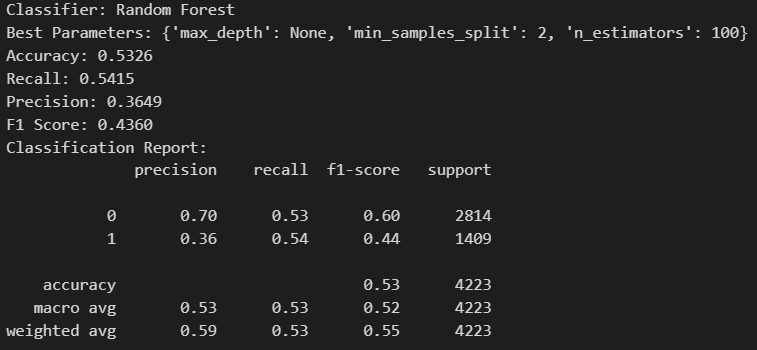
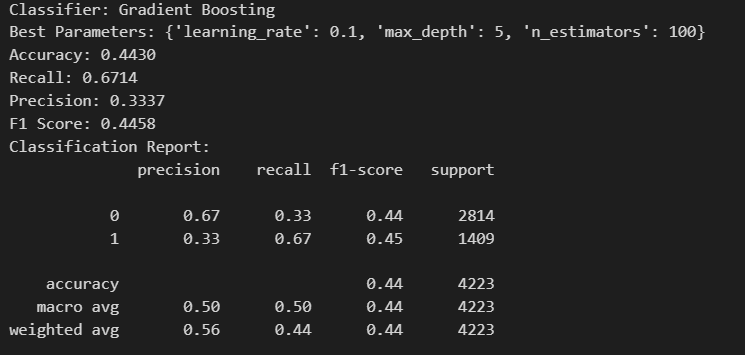
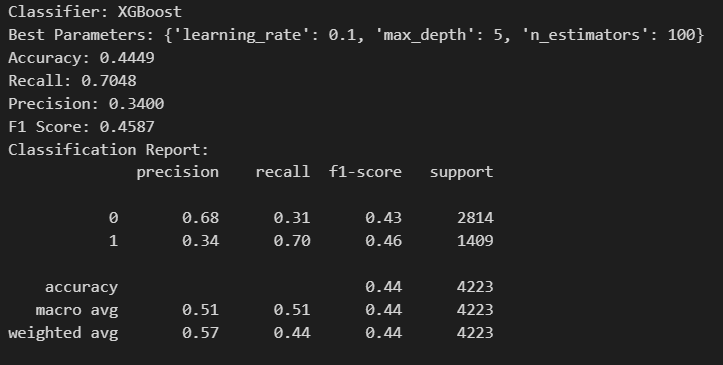

### 3.2 细粒度高糖预测模型的构建 
> 要求：文字描述该过程，包括数据划分、模型构建、参数调优，可视化展示结果并进行分析。

#### 数据划分
1. 设定时间窗口：代码设定了每小时的时间窗口来聚合数据，通过回归模型预测每个小时的高糖次数。
2. 处理重复的时间戳：去除了DataFrame中重复的时间戳记录，保留第一次出现的记录。
3. 聚合非营养数据：计算了加速度、血容脉搏、电皮活动、温度、心率、瞬时心率间隔等非营养数据的平均值和方差。
4. 累积营养数据：对卡路里、总碳水化合物、糖分、蛋白质进行了累积求和。
5. 计算高血糖条件计数：计算了每小时内血糖值大于等于140 mg/dL的次数。
6. 添加时间相关特征：增加了表示小时的列。
7. 计算增量：计算了每个小时相对于前一个小时的变化量。
8. 处理缺失值：使用前向填充方法处理了开头的缺失值。
9. 划分测试集训练集，将9，11划为测试集，其他为训练集
10. 过采样训练集


#### 模型构建与参数调优
1. 模型初始化：定义了四种回归模型——线性回归、支持向量回归（SVR）、随机森林回归和梯度提升回归。
2. 参数调优：对于需要调优的模型（如SVR、随机森林回归和梯度提升回归），使用了GridSearchCV进行参数调优。通过网格搜索确定了最佳参数组合。
3. 模型训练：使用训练集对每个模型进行训练。对于不需要调优的模型（如线性回归），直接进行训练；对于需要调优的模型，则使用网格搜索找到的最佳参数进行训练。

#### 模型评估与结果可视化
1. 模型评估：对于每个模型，在测试集上进行预测，并计算均方误差（MSE）和决定系数（R²）作为评估指标。
2. 可视化结果：使用Matplotlib绘制条形图，比较不同模型的MSE和R²得分。

Linear Regression: Mean Squared Error=8.2344, R^2 Score=0.0464

Support Vector Regression: Mean Squared Error=9.4818, R^2 Score=-0.0981

Random Forest Regression: Mean Squared Error=7.0494, R^2 Score=0.1836

Gradient Boosting Regression: Mean Squared Error=7.4915, R^2 Score=0.1324

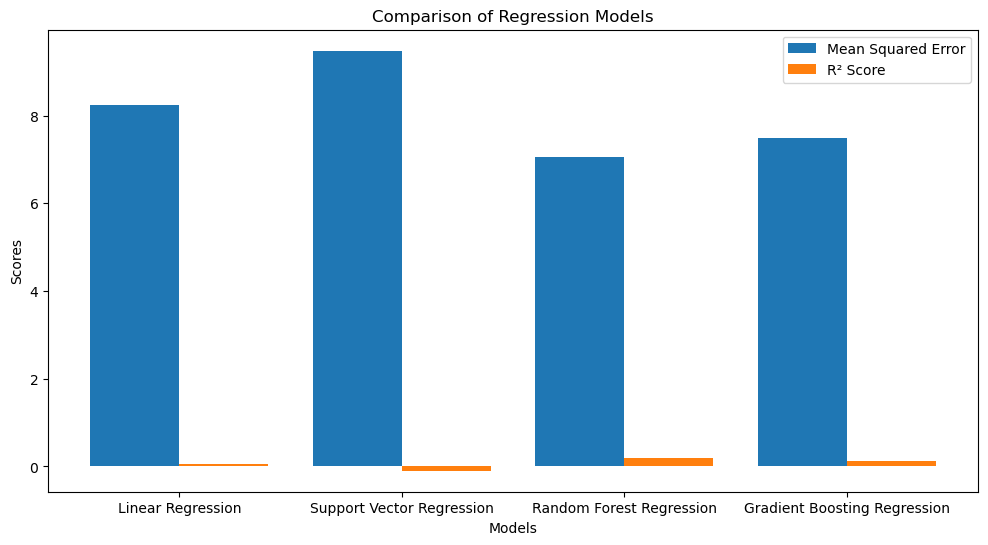

整体来说随机森林模型均方误差更小，但所有模型的R²都很小

### 3.3 高糖次数预测结果展示与分析 
> 要求：文字描述该过程，包括高糖次数预测误差与结果分析。

## 四、项目总结与心得体会 

### 4.1 项目总结
> 要求：请从项目目的、项目流程、数据处理方法、高糖预测模型构建方法、效果分析和初步结论等方面对本项目进行总结。
项目目的：解决了什么样的实际问题？
项目流程：项目的总体执行流程是怎样的？
数据处理方法：对项目数据进行了怎样的处理？
高糖预测模型构建方法：使用了哪些方法构建高糖预测模型？
效果分析：使用哪些方法对高糖预测模型的效果进行了分析与评估？
初步结论：通过本项目，得到了哪些初步的结论？

#### 项目目的
本项目的目的是开发一个能够有效预测个体血糖水平升高（高糖状态）的模型。

#### 项目流程
- 需求分析：确定项目目标，明确需要解决的实际问题。
- 数据预处理：清洗数据，处理缺失值、异常值，统一数据格式，选择合适的时间标签（如time_label列）进行时间序列分析。
- 特征工程：根据领域知识选取或构造有助于预测的特征,通过selectbestfeature选取最好的几个特征。
- 模型训练：选择合适的机器学习算法训练模型，如线性回归、随机森林、支持向量机等。
- 模型验证与优化：通过交叉验证等技术评估模型性能，并通过网格搜索进行调参优化。

#### 数据处理方法
- 数据清洗：去除重复项、处理缺失值，确保数据质量。
- 特征选择：基于相关性分析和血糖相关因素资料，选择与血糖水平变化最相关的特征。
- 时间序列处理：利用time_label列进行时间序列分析，考虑时间上的连续性和周期性影响。

#### 高糖预测模型构建方法
- 算法选择：可能采用线性回归、随机森林、支持向量机、神经网络等算法。
- 模型训练：使用训练集数据训练模型，确保模型能够泛化到未见过的数据。
- 超参数调优：使用网格搜索或随机搜索等方法寻找最佳模型参数。

#### 效果分析
- 性能指标：使用准确率、精确度、召回率、F1分数等指标评估模型性能。
- 误差分析：分析模型预测错误的情况，找出原因。
- 对比实验：与基准模型或其它模型进行比较，验证模型的有效性。

#### 初步结论
- 模型有效性：通过上述方法训练出的模型在测试集上表现良好，能够在一定程度上预测高糖状态。
- 未来工作方向：为进一步提升预测准确性，可以考虑增加更多影响因素的数据，或尝试更复杂的模型结构。


### 4.2 心得体会

> 要求：在该项目实施过程中，遇到了哪些问题？你是如何解决这些问题的？经过本次课程设计，你的最大收获是什么？经过本次课程设计，你有哪些体会？


#### 问题
##### 采样
采样的间隔设置多少合适？
##### 缺失数据处理
缺失的数据如何补全，应桉什么规则补全？
##### 特征工程
特征工程是最大的问题，俗话说数据和特征决定了模型的上限，算法只是在逼近这个上限。但由于特征与标签的关系并不明显，没有明显的相关性，所以训练效果很差。且每个样本用户的生活习惯各不相同，如果不是针对每一个用户训练模型，而是针对所有数据做一个泛化的预测模型，则时间序列在这里的意义被拉小了。因为有的用户是在夜晚出现高糖，而有的用户是饭后出现高糖，更有多数用户并未出现高糖。
##### 类别不平衡
高糖出现的数据远少于正常的数据，这会导致训练时出现偏执。

#### 问题解决
1. 关于采样，最终我选择了1min间隔和5min间隔两版，但后期发现1min数据运行时间太长，转而用5min
2. 关于缺失数据处理，对于大部分时间序列数据，我根据时间进行线性插值。少数统计次数，如统计一小时内的高糖次数，则补0
3. 关于特征工程，这里我没有找到一个合适的解决方法。模型的表现不佳也多与此有关。我查阅数据挖掘的书，其中针对时间序列数据，均值反应一段时间内的总体情况，方差反应一段时间内的波动情况，增值反应一段时间内的上升下降趋势，对于文本离散数据可以进行哑编码，但由于我都是时间序列数据，有一定的时间顺序，不需要进行哑编码。但以上的构造特征作用都十分有限。于是我转而使用新的数据food_log，这组数据包含了摄入的糖分，卡路里等信息，特征与目标变量的相关性比可穿戴设备采集的所有信息都要强。
4. 关于类别不平衡，我们通过smote过采样到正负样本数量一致。



## 五、完整项目代码整理
> 要求：任务说明+代码及关键代码注释+可视化与运行结果

In [17]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [18]:
### 任务点1.1 数据采样与整合

In [19]:
# 根据Dexcom五分钟间隔采样，
import pandas as pd

# 定义文件编号列表
file_nums = [f'{i:03d}' for i in range(2, 17)]  # 生成从 '002' 到 '016' 的文件编号

for file_num in file_nums:
    # 读取各个CSV文件
    Dexcom = pd.read_csv(f'data/{file_num}/Dexcom_{file_num}.csv', skiprows=13, header=None)
    Dexcom = Dexcom[[1, 7]]
    Dexcom.columns = ['datetime', 'Glucose Value (mg/dL)']
    Dexcom['datetime'] = pd.to_datetime(Dexcom['datetime'])

    ACC = pd.read_csv(f'data/{file_num}/ACC_{file_num}.csv')
    ACC['datetime'] = pd.to_datetime(ACC['datetime'])

    BVP = pd.read_csv(f'data/{file_num}/BVP_{file_num}.csv')
    BVP['datetime'] = pd.to_datetime(BVP['datetime'])

    EDA = pd.read_csv(f'data/{file_num}/EDA_{file_num}.csv')
    EDA['datetime'] = pd.to_datetime(EDA['datetime'])

    IBI = pd.read_csv(f'data/{file_num}/IBI_{file_num}.csv')
    IBI['datetime'] = pd.to_datetime(IBI['datetime'])

    TEMP = pd.read_csv(f'data/{file_num}/TEMP_{file_num}.csv')
    TEMP['datetime'] = pd.to_datetime(TEMP['datetime'])
    
    HR = pd.read_csv(f'data/{file_num}/HR_{file_num}.csv')
    HR['datetime'] = pd.to_datetime(HR['datetime'])
    
    IBI = IBI.sort_values(by='datetime')
    # 合并数据框
    merged_data = Dexcom.merge(ACC, on='datetime', how='inner')
    merged_data = merged_data.merge(BVP, on='datetime', how='inner')
    merged_data = merged_data.merge(EDA, on='datetime', how='inner')
    merged_data = merged_data.merge(TEMP, on='datetime', how='inner')
    merged_data = merged_data.merge(HR, on='datetime', how='inner')
    merged_data = pd.merge_asof(
        left=merged_data,
        right=IBI,
        on='datetime',
        by=None,
        tolerance=pd.Timedelta('60s'),
        direction='nearest'
    )

    # 处理缺失值
    for column in merged_data.columns:
        if merged_data[column].isna().any():
            mean_value = merged_data[column].mean()
            merged_data[column] = merged_data[column].fillna(mean_value)

    # 保存每个文件处理后的数据到单独的CSV文件
    output_file_path = f'processed_data/processed_data_{file_num}.csv'
    merged_data.to_csv(output_file_path, index=False)
    print(f'Processed and saved data for file number {file_num}')



Processed and saved data for file number 002
Processed and saved data for file number 003
Processed and saved data for file number 004
Processed and saved data for file number 005
Processed and saved data for file number 006
Processed and saved data for file number 007
Processed and saved data for file number 008
Processed and saved data for file number 009
Processed and saved data for file number 010
Processed and saved data for file number 011
Processed and saved data for file number 012
Processed and saved data for file number 013
Processed and saved data for file number 014
Processed and saved data for file number 015
Processed and saved data for file number 016


### 任务点1.2 缺失值处理与异常值检测

In [20]:
# 请在下方完成任务
# 缺失值补为平均值

# 定义文件编号列表
file_nums = [f'{i:03d}' for i in range(2, 17)]  # 生成从 '001' 到 '016' 的文件编号

for file_num in file_nums:
    # 处理缺失值
    merged_data=pd.read_csv(f'processed_data/processed_data_{file_num}.csv')
    for column in merged_data.columns:
        if merged_data[column].isna().any():
            mean_value = merged_data[column].mean()
            merged_data[column] = merged_data[column].fillna(mean_value)

    # 保存每个文件处理后的数据到单独的CSV文件
    output_file_path = f'processed_data/processed_data_{file_num}.csv'
    merged_data.to_csv(output_file_path, index=False)
    print(f'Processed and saved data for file number {file_num}')


Processed and saved data for file number 002
Processed and saved data for file number 003
Processed and saved data for file number 004
Processed and saved data for file number 005
Processed and saved data for file number 006
Processed and saved data for file number 007
Processed and saved data for file number 008
Processed and saved data for file number 009
Processed and saved data for file number 010
Processed and saved data for file number 011
Processed and saved data for file number 012
Processed and saved data for file number 013
Processed and saved data for file number 014
Processed and saved data for file number 015
Processed and saved data for file number 016


### 任务点1.3 数据归一化

由于数据的不同特征属性值的差异较大，并不利于模型的选择和使用，所以要对数据完成归一化操作。

In [21]:
# 请在下方完成任务，并保存处理的样本矩阵到本地
file_nums = [f'{i:03d}' for i in range(2, 17)]  # 生成从 '002' 到 '016' 的文件编号

for file_num in file_nums:
    # 读取 CSV 文件
    merged_data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')
    
    # 对每一列进行归一化处理
    for column in merged_data.columns[2:]:  # 从第三列开始
        if merged_data[column].dtype in ['float64', 'int64']:  # 只对数值类型的数据列进行归一化
            column_max = merged_data[column].max()
            column_min = merged_data[column].min()
            if column_max != column_min:  # 避免除以0的情况
                merged_data[column] = (merged_data[column] - column_min) / (column_max - column_min)
    
    # 保存每个文件处理后的数据到单独的CSV文件
    output_file_path = f'processed_data/processed_data_{file_num}.csv'
    merged_data.to_csv(output_file_path, index=False)
    print(f'Normalized and saved data for file number {file_num}')

Normalized and saved data for file number 002
Normalized and saved data for file number 003
Normalized and saved data for file number 004
Normalized and saved data for file number 005
Normalized and saved data for file number 006
Normalized and saved data for file number 007
Normalized and saved data for file number 008
Normalized and saved data for file number 009
Normalized and saved data for file number 010
Normalized and saved data for file number 011
Normalized and saved data for file number 012
Normalized and saved data for file number 013
Normalized and saved data for file number 014
Normalized and saved data for file number 015
Normalized and saved data for file number 016


### 任务点1.4 血糖值可视化与时间属性离散化（阶段化）

不同用户每天的血糖值不断变化。通过可视化来观测不同用户一天血糖值的变化规律、高糖出现的时间、频率等。

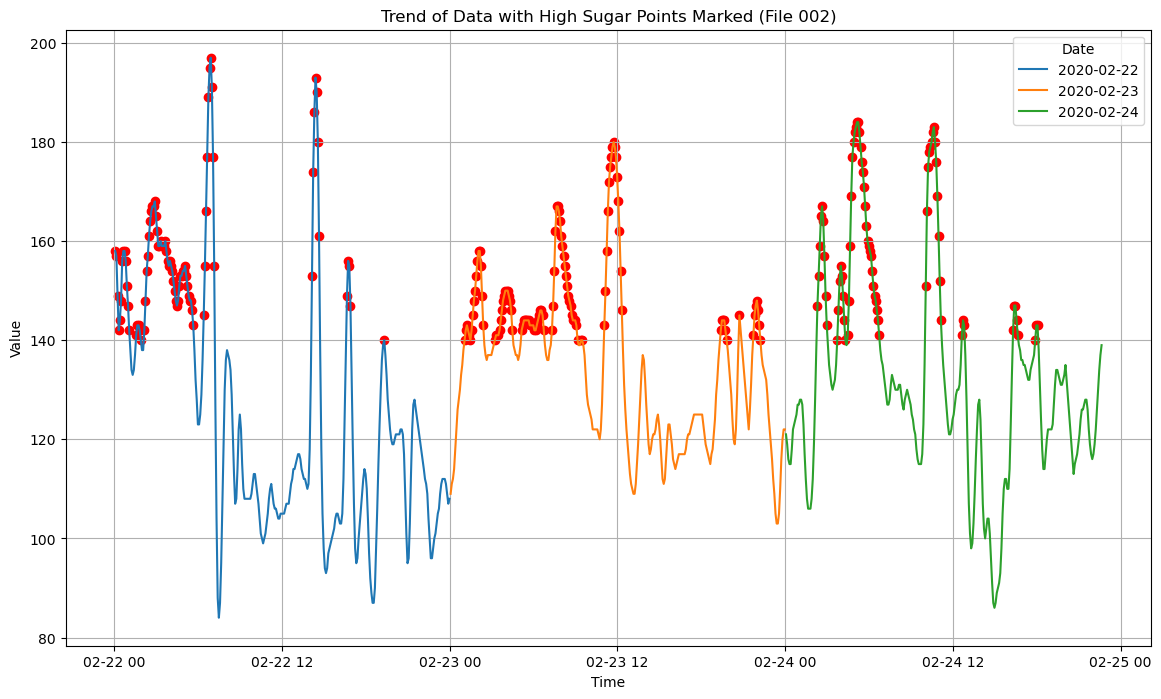

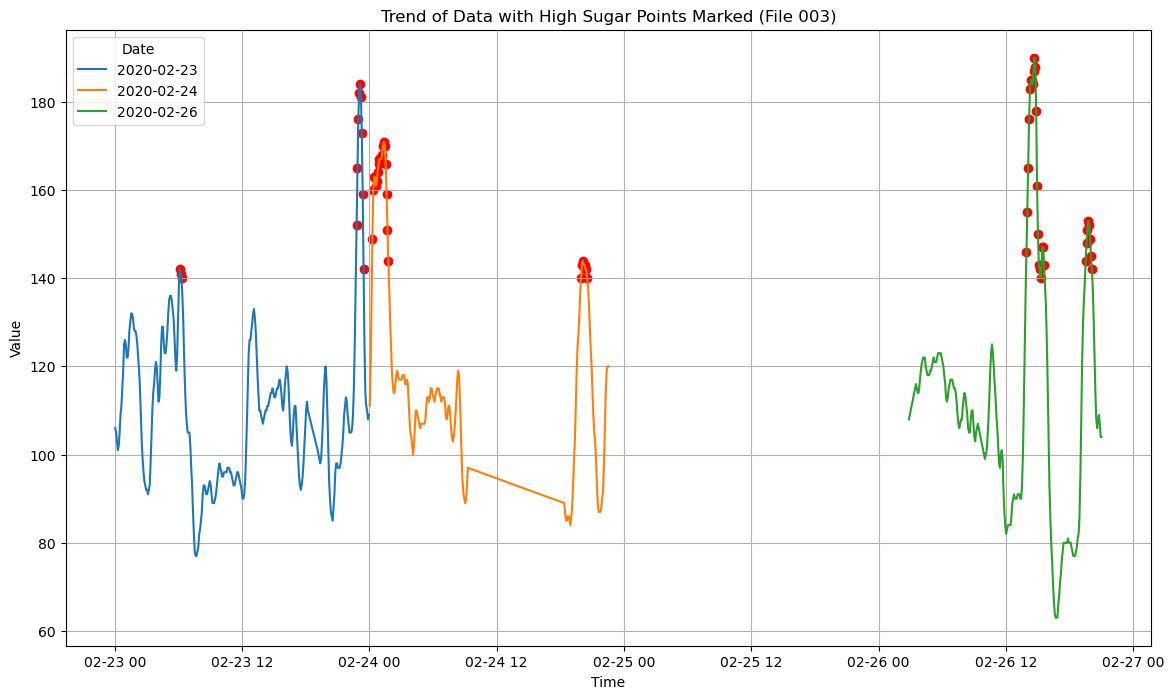

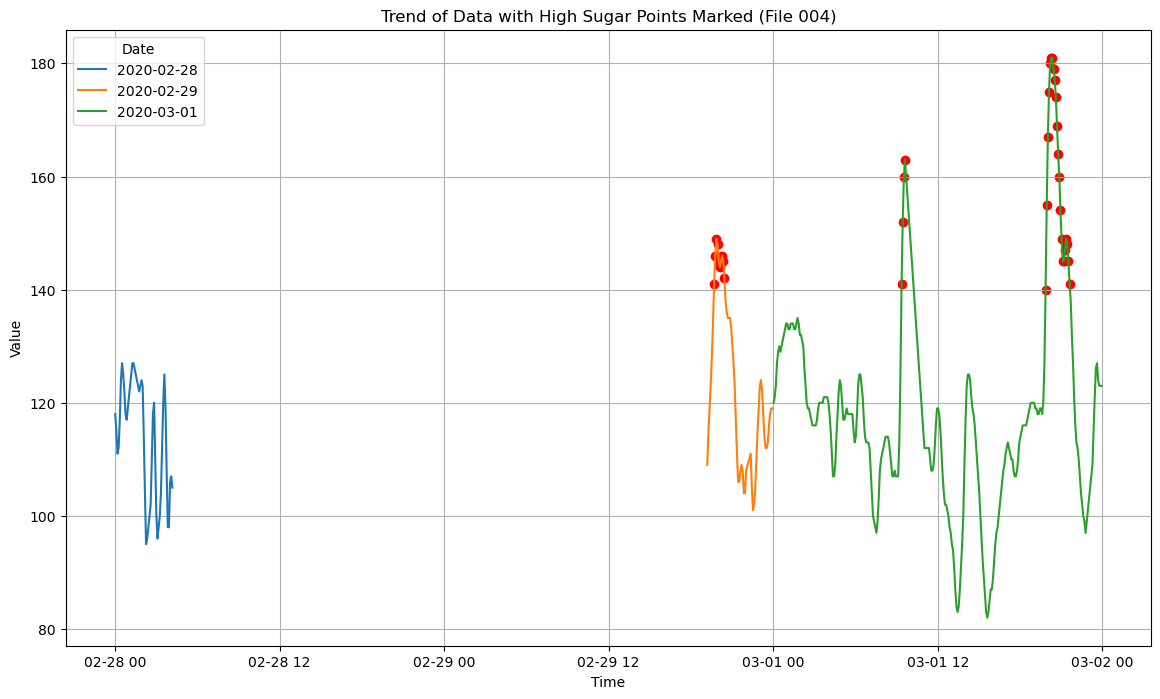

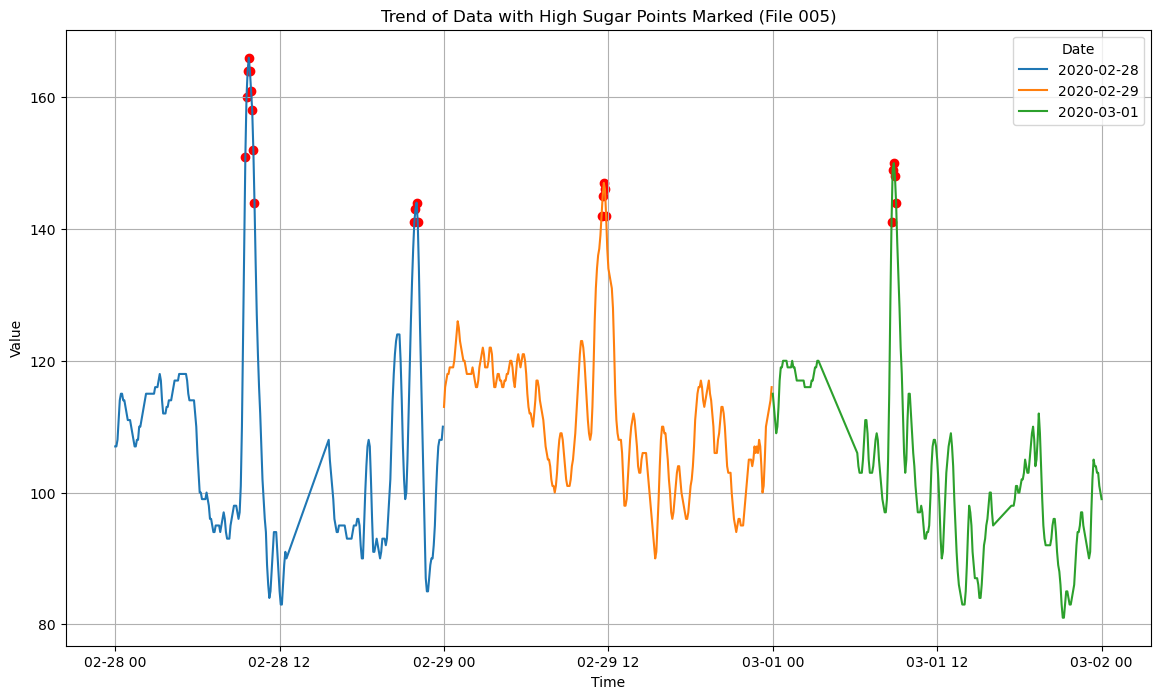

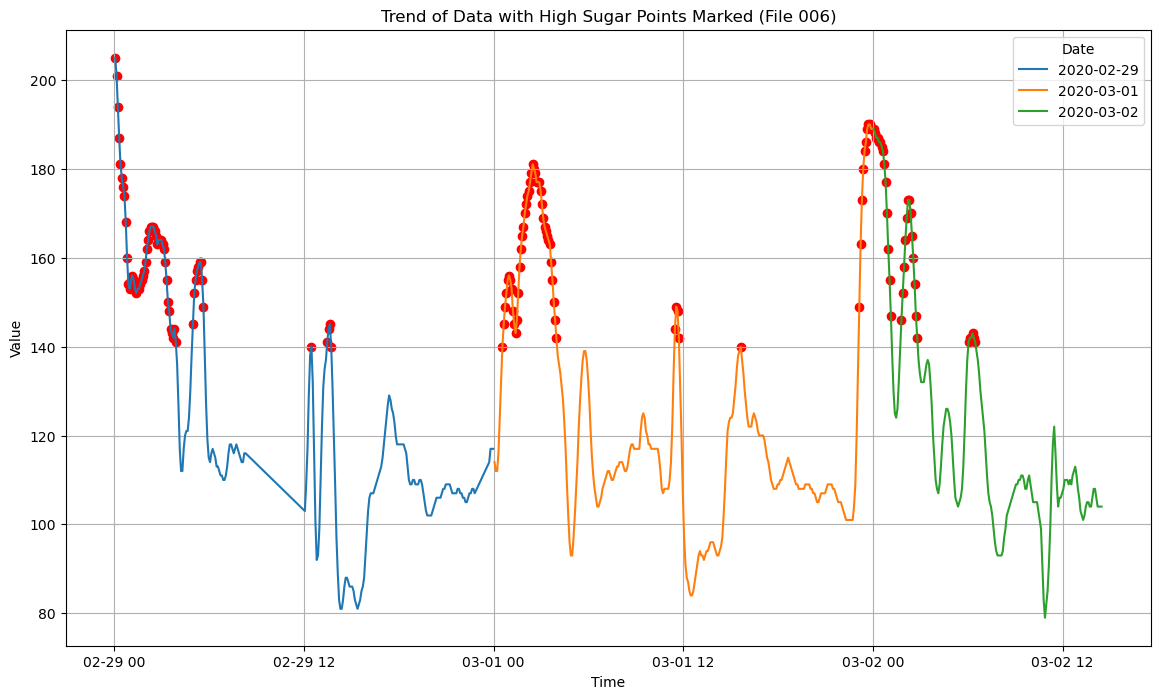

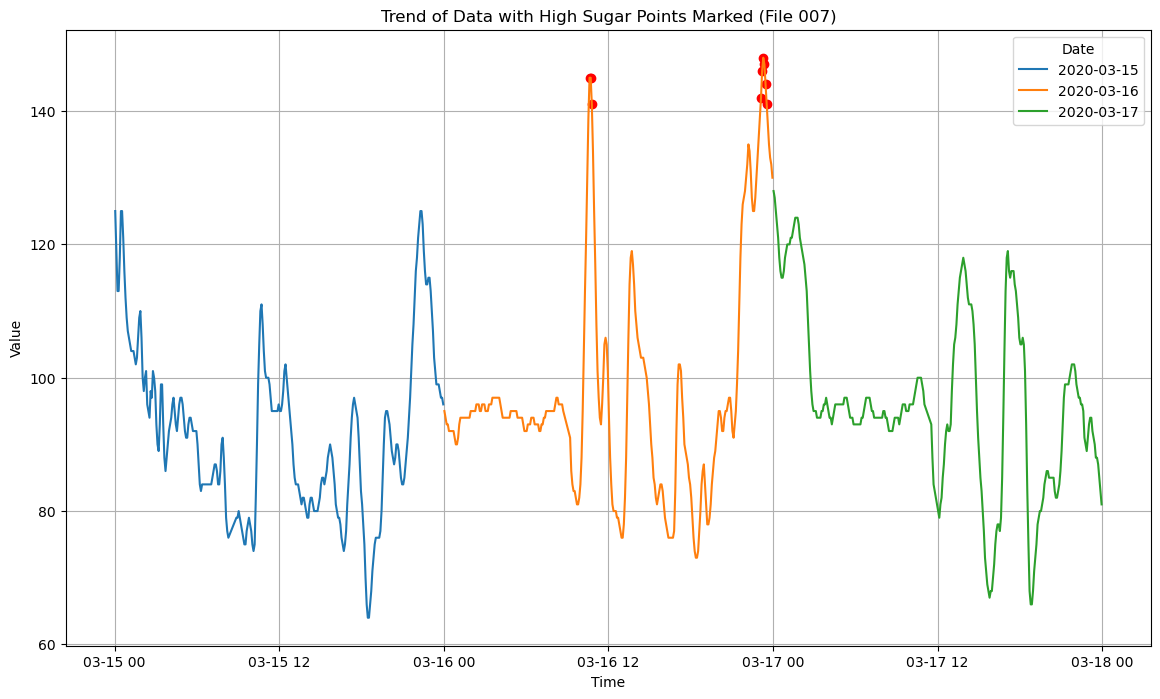

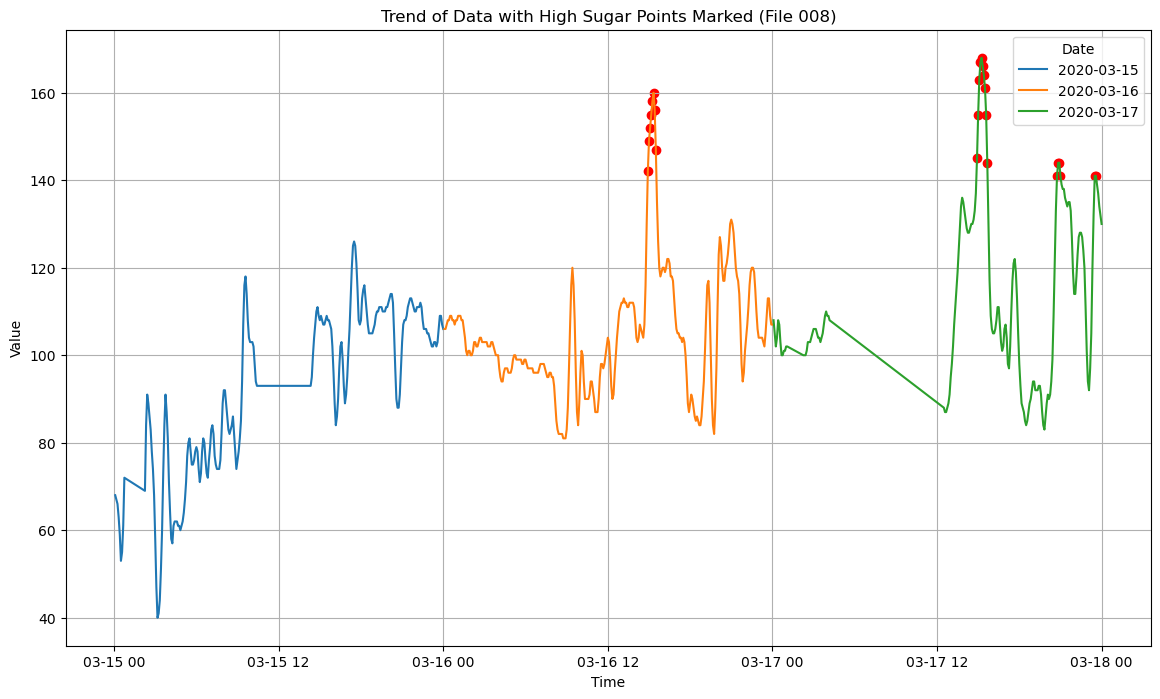

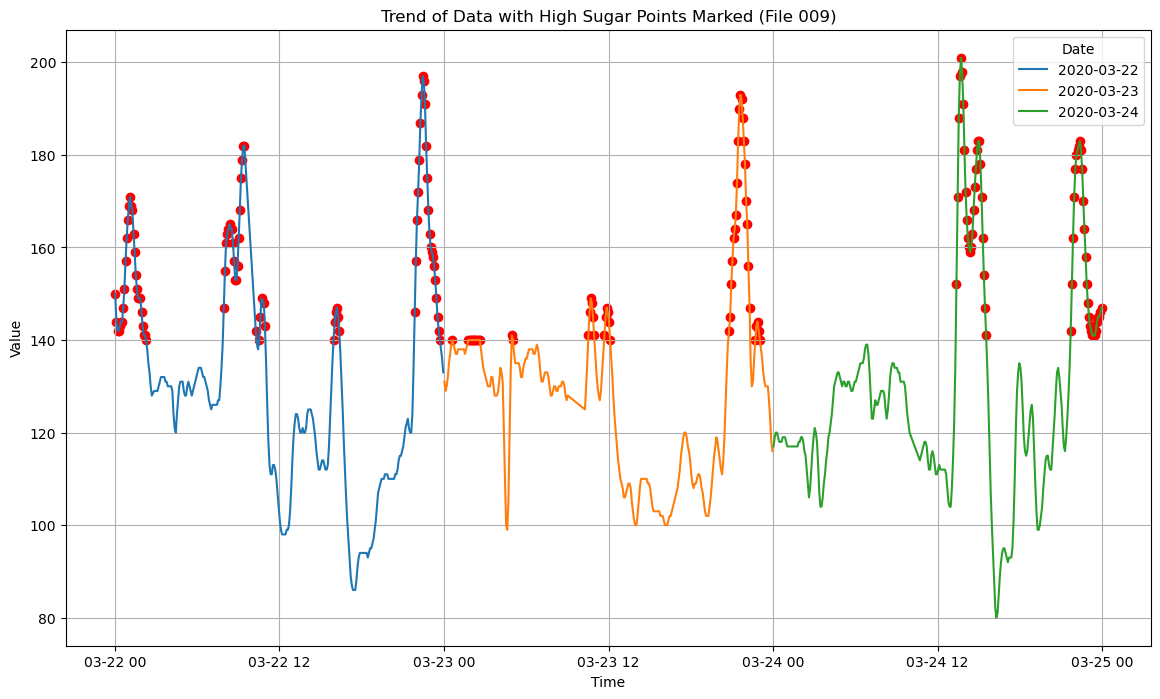

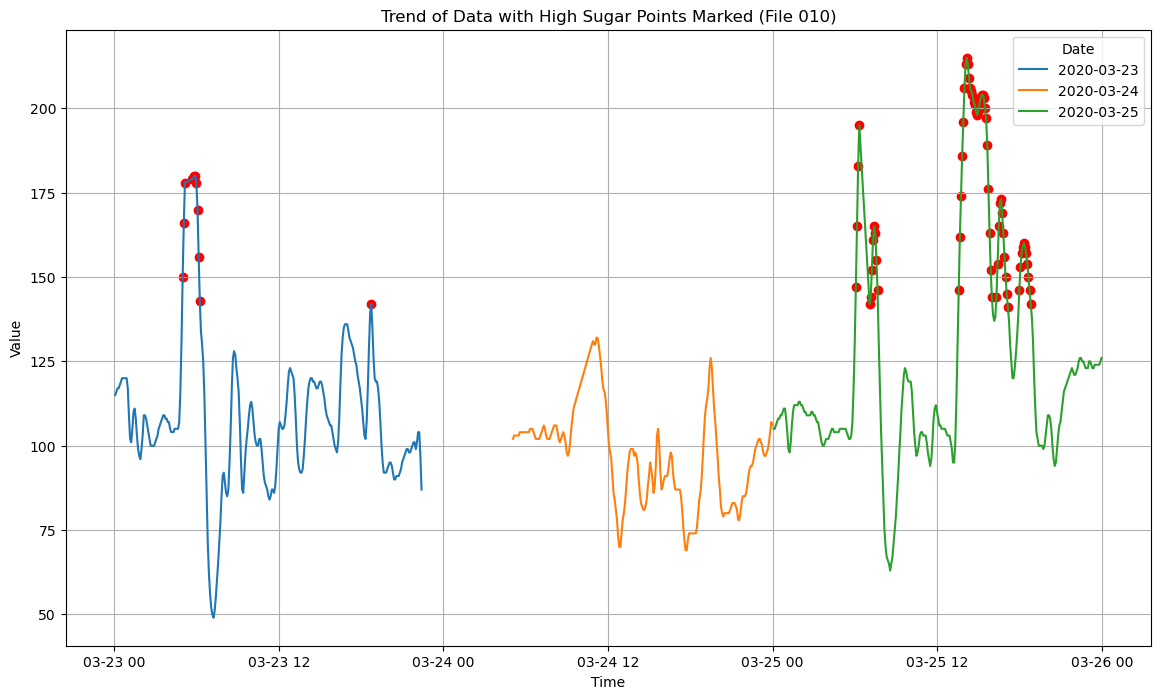

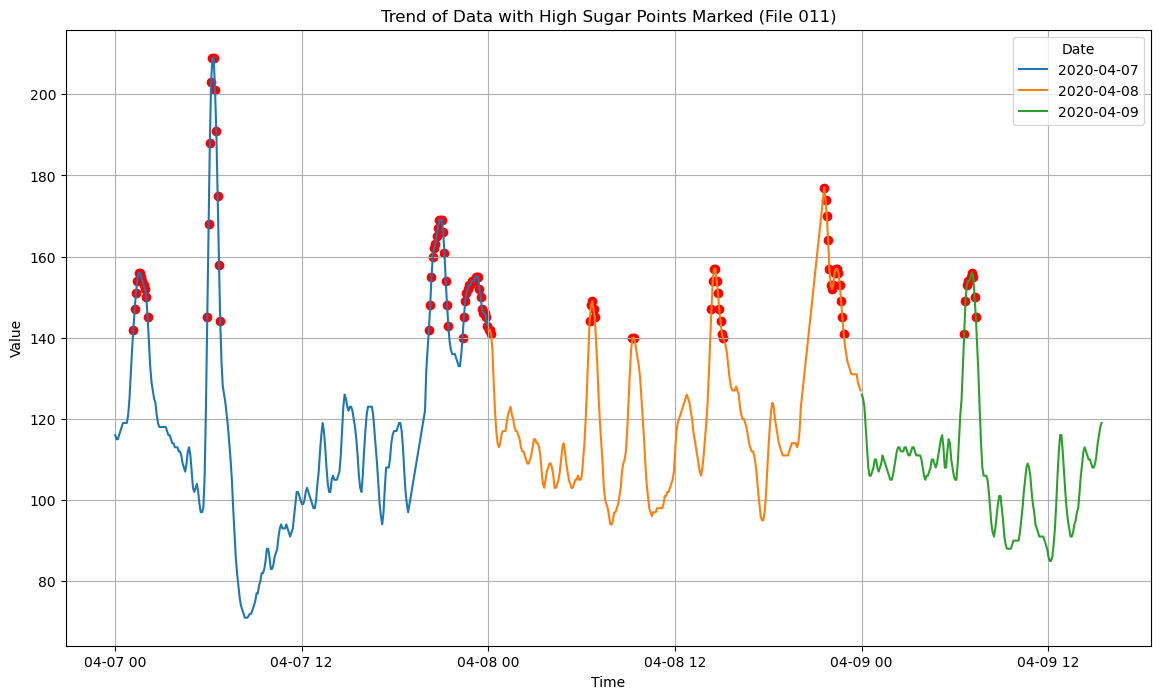

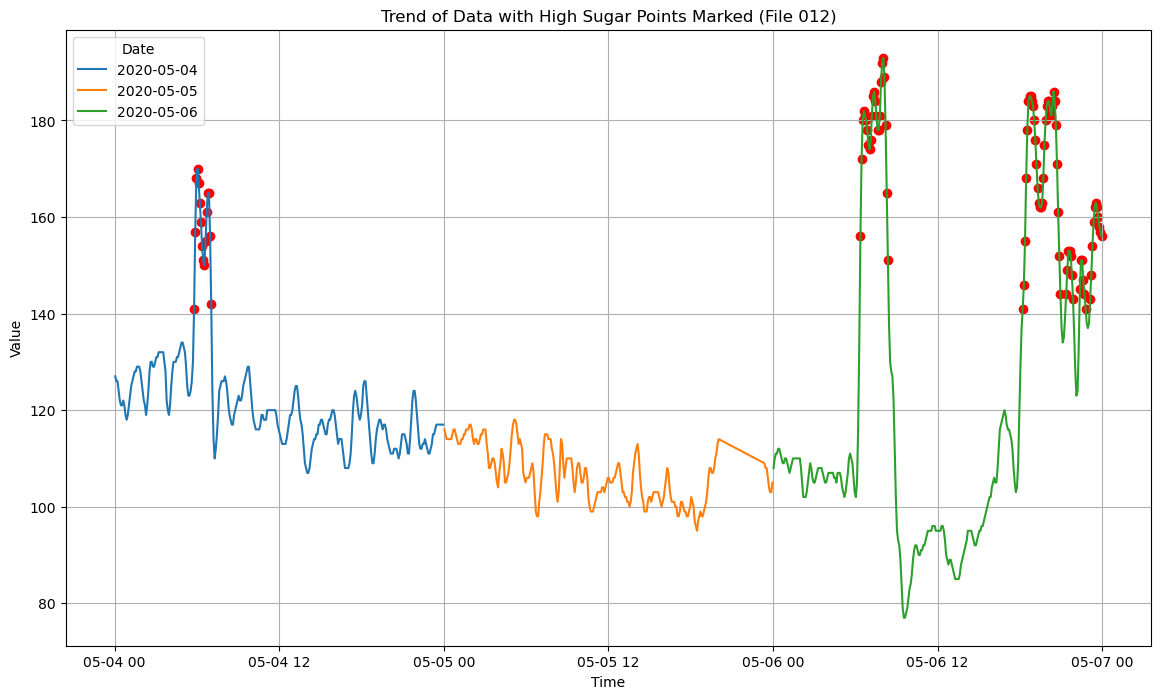

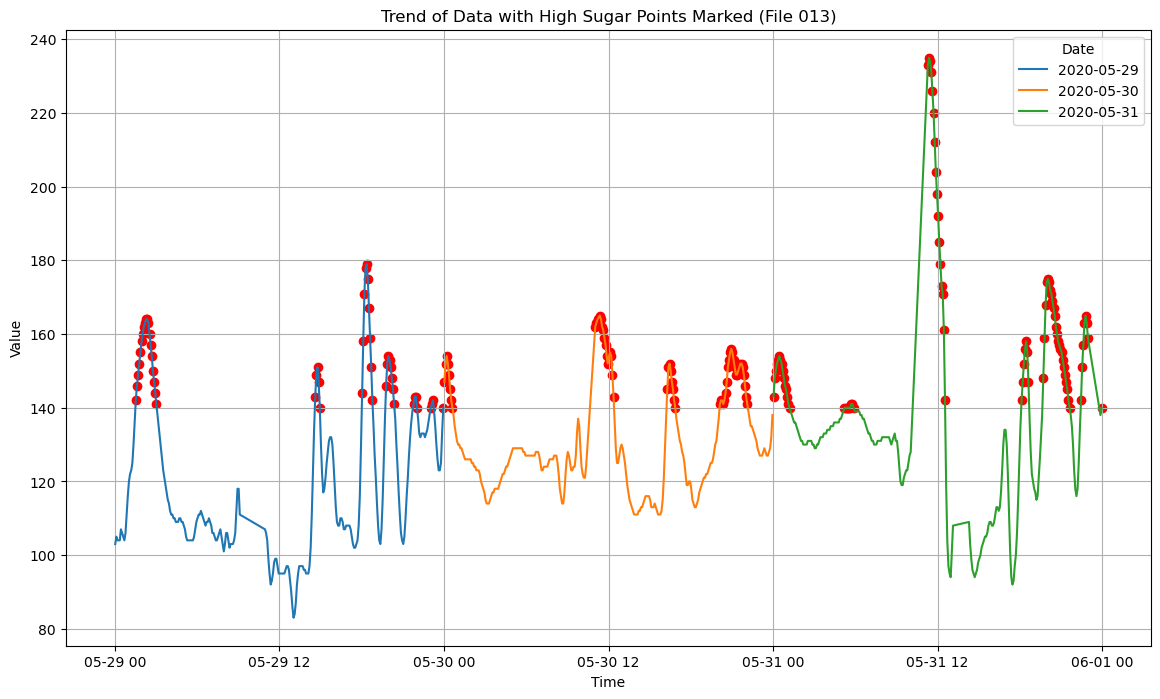

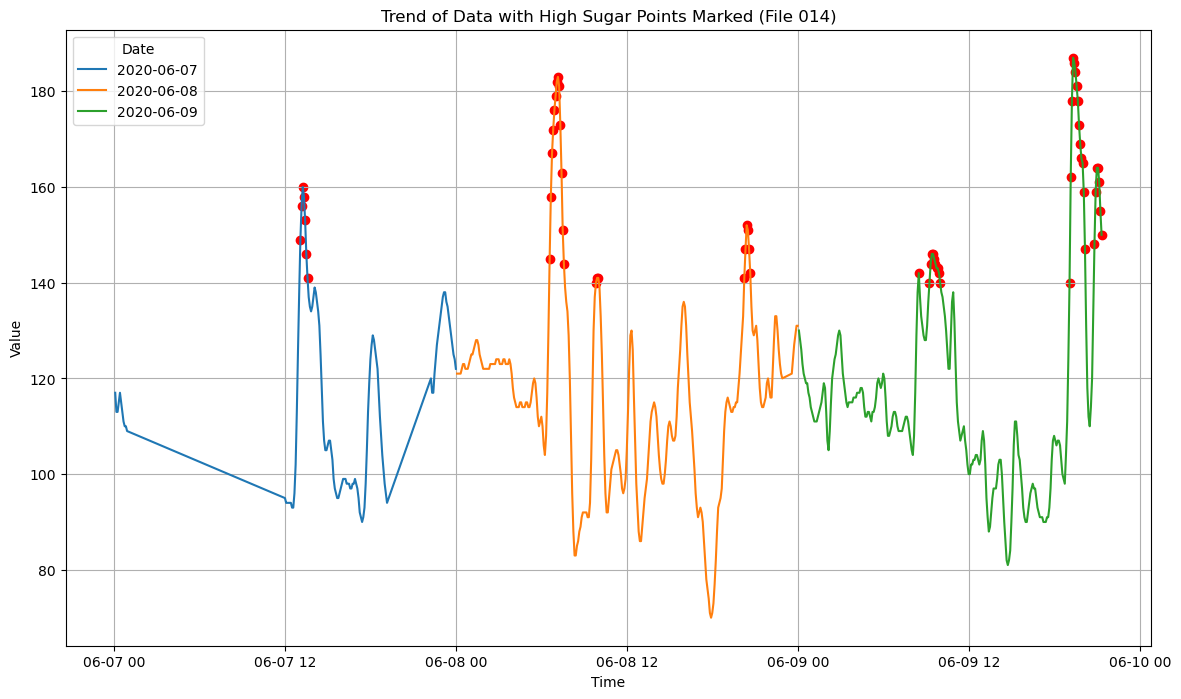

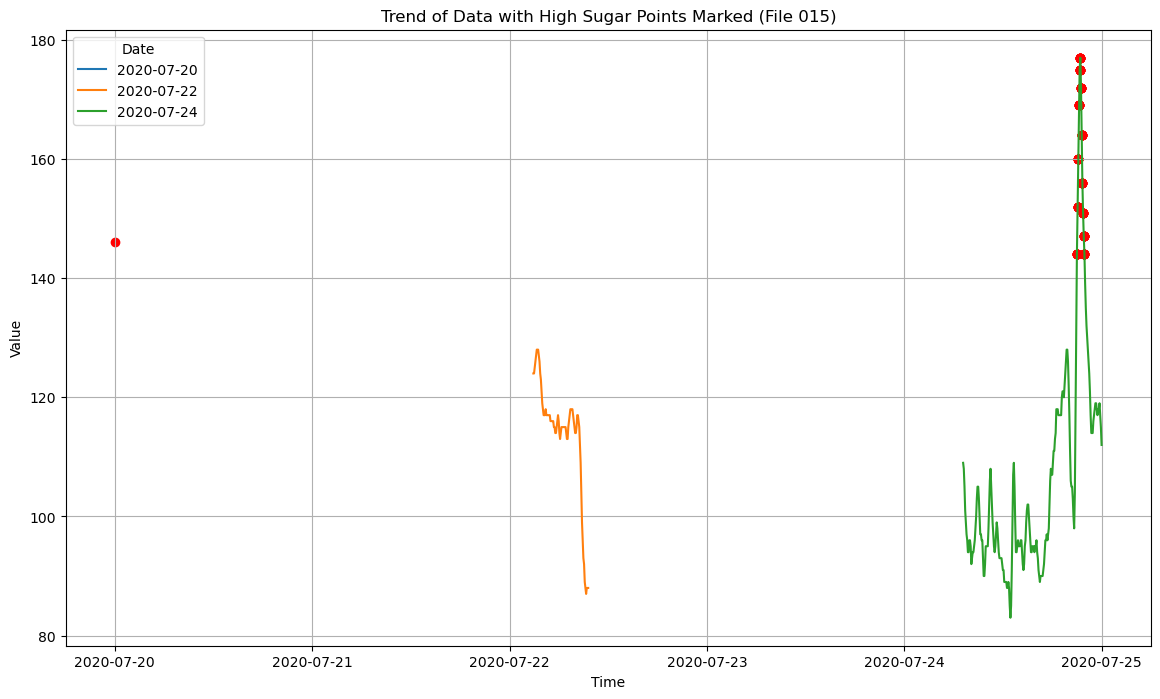

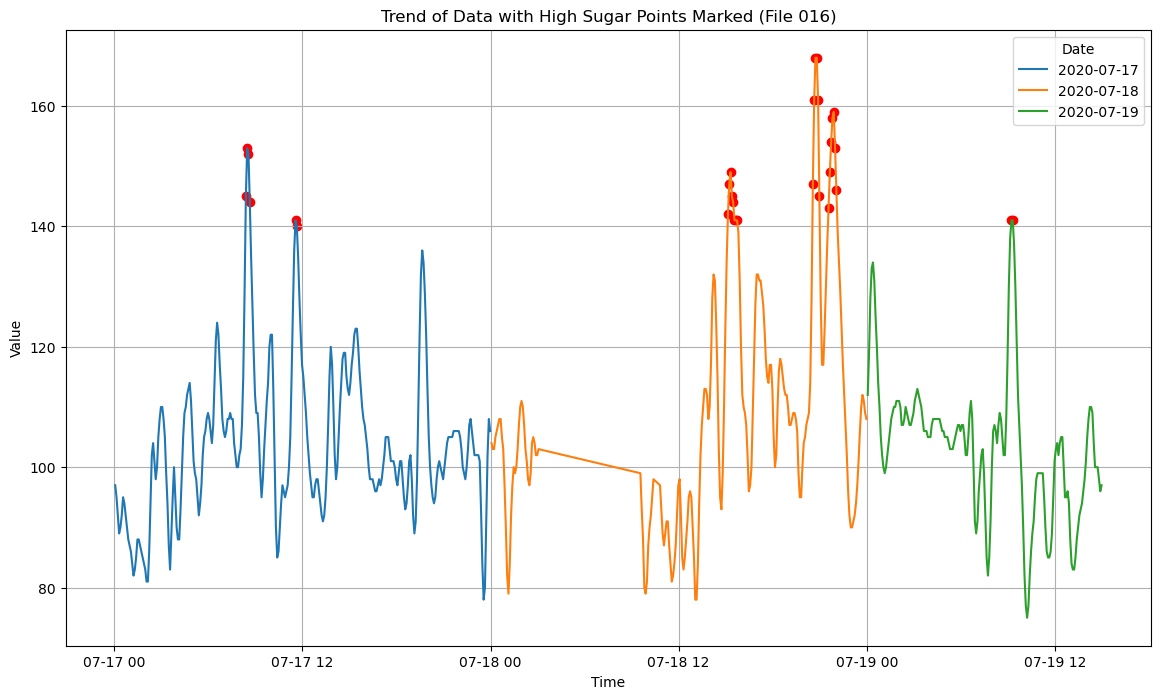

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 定义高糖阈值
gaotang = 140

# 获取所有文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 对每个文件编号进行处理
for file_num in file_nums:
    # 获取该用户的所有文件
    user_files = [f for f in os.listdir('processed_data') if f.startswith(f'processed_data_{file_num}') and f.endswith('.csv')]
    
    # 存储所有日期
    all_dates = []
    
    # 遍历这些文件
    for target_file in user_files:
        # 读取 CSV 文件
        data = pd.read_csv(os.path.join('processed_data', target_file))
        
        # 将第一列转换为 datetime 类型
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # 添加日期到列表
        all_dates.extend(data['datetime'].dt.date.unique())
    
    # 去除重复日期并排序
    all_dates = sorted(set(all_dates))
    
    # 取第二天、第三天、第四天的日期
    target_dates = all_dates[1:4]
    
    # 创建一个新的 figure 用于绘制所有目标日期的数据
    plt.figure(figsize=(14, 8))

    # 再次遍历这些文件并绘制图表
    for target_file in user_files:
        # 读取 CSV 文件
        data = pd.read_csv(os.path.join('processed_data', target_file))
        
        # 将第一列转换为 datetime 类型
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # 遍历目标日期并绘制图形
        for target_date in target_dates:
            # 过滤出目标日期的数据
            day_data = data[data['datetime'].dt.date == target_date]
            
            # 如果该天没有数据，则跳过
            if day_data.empty:
                continue
            
            # 绘制折线图
            plt.plot(day_data['datetime'], day_data.iloc[:, 1], label=target_date.strftime('%Y-%m-%d'))

            # 标出高糖值
            high_sugar_points = day_data[day_data.iloc[:, 1] >= gaotang]
            plt.scatter(high_sugar_points['datetime'], high_sugar_points.iloc[:, 1], color='red')

    plt.title(f'Trend of Data with High Sugar Points Marked (File {file_num})')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(title='Date')
    plt.grid(True)

    # 显示图形
    plt.show()

### 任务点1.5 时间属性离散化（阶段化）

为了预测每人在一天内的不同阶段是否会发生高糖，根据任务点1.4的观测结果，完成时间属性的离散化（阶段化）任务。例如，将一天划分为不同的阶段，分阶段预测是否发生高糖。具体的分段方法可自行决定，例如5分钟、1个小时、半天、上中下晚夜等。
并根据分段结果，构造每个的阶段的目标值（是否高糖），形成一列数据。

In [23]:
# 增加一列time_label_num和hour_label，将时间段分标签，并将时间段标签映射到数字
import pandas as pd

# 生成从 '002' 到 '016' 的文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 定义时间段和对应的标签
time_segments = [
    ('00:00:00', '03:59:59', '深夜'),
    ('04:00:00', '05:59:59', '凌晨'),
    ('06:00:00', '10:59:59', '上午'),
    ('11:00:00', '12:59:59', '中午'),
    ('13:00:00', '16:59:59', '下午'),
    ('17:00:00', '18:59:59', '傍晚'),
    ('19:00:00', '23:59:59', '晚上'),
]

# 创建一个映射字典，将时间段标签映射到数字
time_segment_mapping = {label: idx for idx, (_, _, label) in enumerate(time_segments)}

# 定义函数来分配时间段标签
def assign_time_segment(row, segments=time_segments):
    row_time = row['datetime'].time()
    for start, end, label in segments:
        if pd.to_datetime(start, format='%H:%M:%S').time() <= row_time <= pd.to_datetime(end, format='%H:%M:%S').time():
            return label
    return None

# 定义函数来转换标签为数字
def convert_label_to_number(row, mapping=time_segment_mapping):
    return mapping.get(row['time_label'], -1)

# 对每个文件应用时间标签
for file_num in file_nums:
    # 加载数据
    data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')
    
    # 将第一列转换为 datetime 类型
    data['datetime'] = pd.to_datetime(data['datetime'])
    
    # 应用函数并创建新列 'time_label'
    data['time_label'] = data.apply(assign_time_segment, axis=1)
    
    # 转换时间标签为数字编码
    data['time_label_num'] = data.apply(convert_label_to_number, axis=1)
    
    # 从 'datetime' 列中提取小时部分，并创建 'hour_label' 列
    data['hour_label'] = data['datetime'].dt.hour
    
    # 删除临时 'time_label' 列
    data.drop('time_label', axis=1, inplace=True)
    
    # 保存修改后的数据
    data.to_csv(f'processed_data/processed_data_{file_num}.csv', index=False)

    print(f'file{file_num} labeled with hour_label')

file002 labeled with hour_label
file003 labeled with hour_label
file004 labeled with hour_label
file005 labeled with hour_label
file006 labeled with hour_label
file007 labeled with hour_label
file008 labeled with hour_label
file009 labeled with hour_label
file010 labeled with hour_label
file011 labeled with hour_label
file012 labeled with hour_label
file013 labeled with hour_label
file014 labeled with hour_label
file015 labeled with hour_label


PermissionError: [Errno 13] Permission denied: 'processed_data/processed_data_016.csv'

In [24]:
# 增加food_log.csv
import pandas as pd
from datetime import timedelta

# 生成从 '002' 到 '016' 的文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 定义一个函数来查找最近的时间点
def find_nearest_time(row, df, time_col='datetime', minutes=5):
    # 获取当前行的时间点
    current_time = row[time_col]
    # 计算时间窗口
    start_time = current_time - pd.Timedelta(minutes=minutes, unit='m')
    end_time = current_time + pd.Timedelta(minutes=minutes, unit='m')
    
    # 在 df 中查找落在时间窗口内的记录
    # 确保 start_time 和 end_time 与 df[time_col] 同a类型
    filtered_df = df.loc[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
    if not filtered_df.empty:
        return filtered_df.iloc[0].name
    else:
        return None


for file_num in file_nums:
    # 加载数据
    data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')
    # print(data.head())
    # 将 datetime 列转换为 datetime 对象
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.columns = data.columns.str.strip()  
    # 去遍历food_log.csv 每个时间去找到离它五分钟内的时间，将calorie，total_carb，sugar,protein加到后面去，形成新的特征列
    food_log = pd.read_csv(f'food_log/Food_Log_{file_num}.csv')
    food_log.columns = food_log.columns.str.strip()
    # 我们将它们合并成一个 datetime 对象
    # print(f'{file_num}')
    food_log['datetime'] = pd.to_datetime(food_log['date'] + ' ' + food_log['time'])
     # 将 datetime 列转换为 datetime 对象
    food_log['datetime'] = pd.to_datetime(food_log['datetime'])
    # 应用函数，并创建一个新的索引列以追踪最近的时间点
    food_log['nearest_index'] = food_log.apply(find_nearest_time, axis=1, args=(data,))

    # 基于找到的索引，将营养信息添加到 data DataFrame 中
    data_with_nutrition = data.copy()
    data_with_nutrition['calorie'] = None
    data_with_nutrition['total_carb'] = None
    data_with_nutrition['sugar'] = None
    data_with_nutrition['protein'] = None

    # 遍历 food_log 中的每一行
    for index, row in food_log.iterrows():
        nearest_index = row['nearest_index']
        if nearest_index is not None:
            # 更新 data_with_nutrition 中的相应行
            data_with_nutrition.at[nearest_index, 'calorie'] = row['calorie']
            data_with_nutrition.at[nearest_index, 'total_carb'] = row['total_carb']
            data_with_nutrition.at[nearest_index, 'sugar'] = row['sugar']
            data_with_nutrition.at[nearest_index, 'protein'] = row['protein']

    # 将未匹配到的营养信息列填充为0.0（浮点数）
    data_with_nutrition[['calorie', 'total_carb', 'sugar', 'protein']] = data_with_nutrition[['calorie', 'total_carb', 'sugar', 'protein']].astype(float).fillna(0.0)

    # 保存处理后的数据
    data_with_nutrition.to_csv(f'processed_data/processed_data_{file_num}.csv', index=False)

    print(f'processed_data_{file_num}.csv saved')


processed_data_002.csv saved
processed_data_003.csv saved
processed_data_004.csv saved
processed_data_005.csv saved
processed_data_006.csv saved
processed_data_007.csv saved
processed_data_008.csv saved
processed_data_009.csv saved
processed_data_010.csv saved
processed_data_011.csv saved
processed_data_012.csv saved
processed_data_013.csv saved
processed_data_014.csv saved
processed_data_015.csv saved
processed_data_016.csv saved


最终得到处理过后的数据全部在processed_data中，格式如下：
datetime,Glucose Value (mg/dL), acc_x, acc_y, acc_z, bvp, eda, temp, ibi,time_label_num,hour_label
2020-02-21 11:08:36,186.0,0.3530385433908725,0.5987683562292753,0.9682968788400098,0.5670097914309226,0.0142822433851519,0.8179871520342614,0.2837837487233018,3,11

### 任务点2.1 时序特征的可视化与特征提取

对于一个属性特征（例如BVP），每个阶段的特征都是一条时间序列，通过可视化分析不同特征的变化规律，并选择合适的特征提取方法提前特征，反映其特点。例如提取时序特征的统计量，如最大值（max）、最小值（min）、均值（mean）、方差（variance）等，或者对时序特征进行建模。

C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3031747850.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data[column] = (day_data[column] - min_val) / (max_val - min_val)


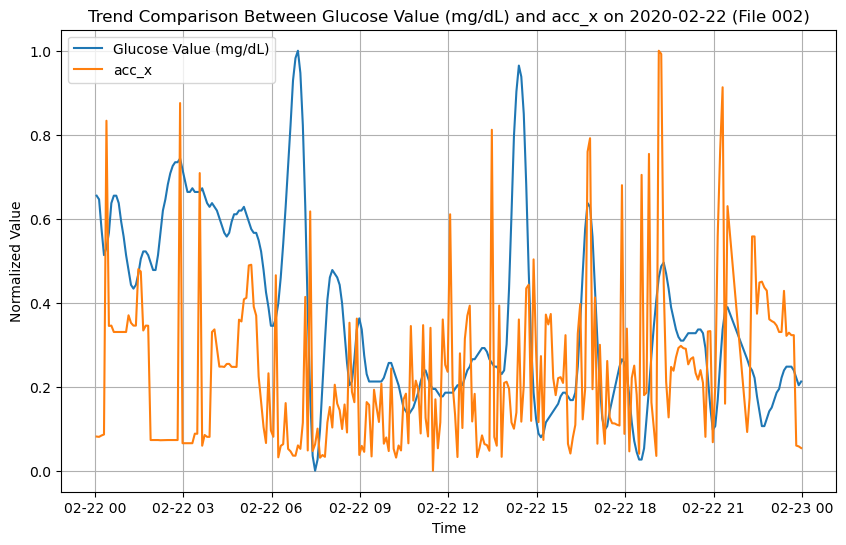

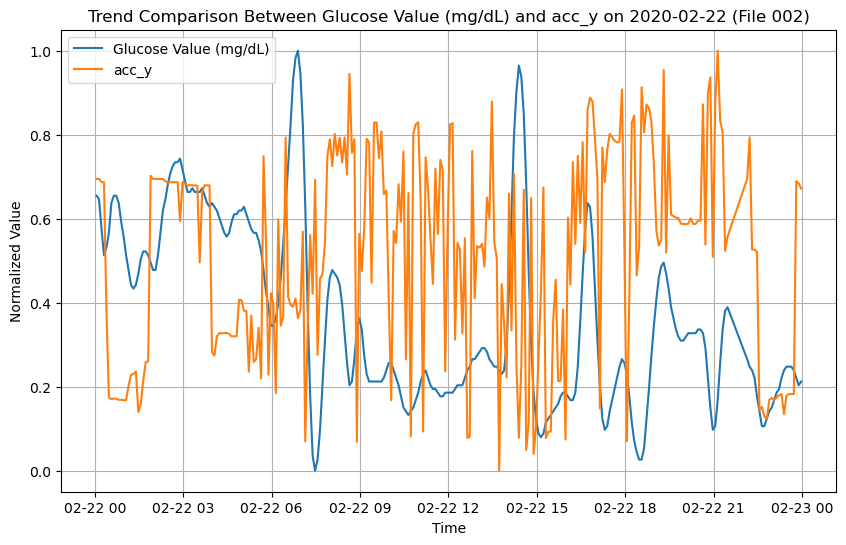

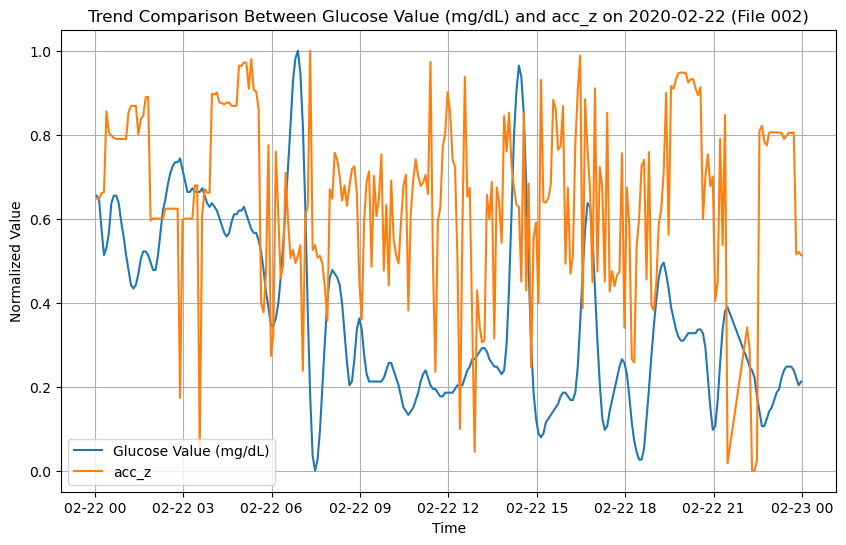

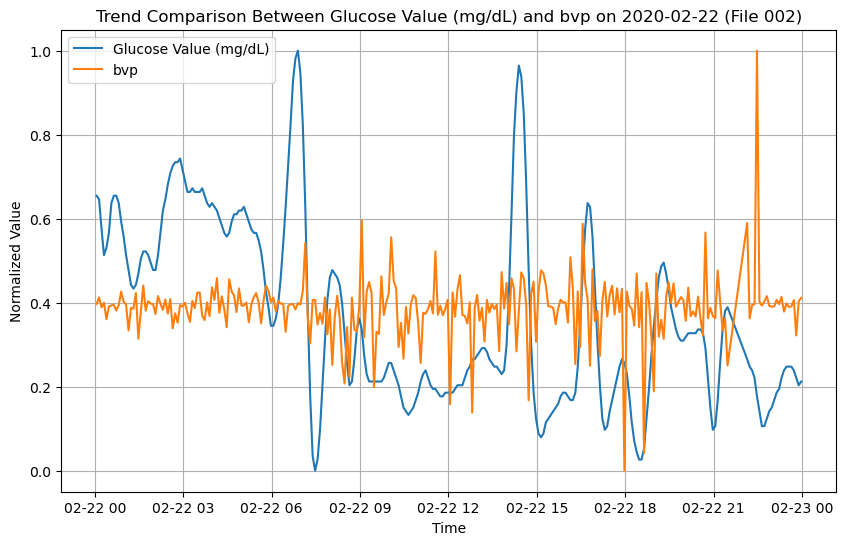

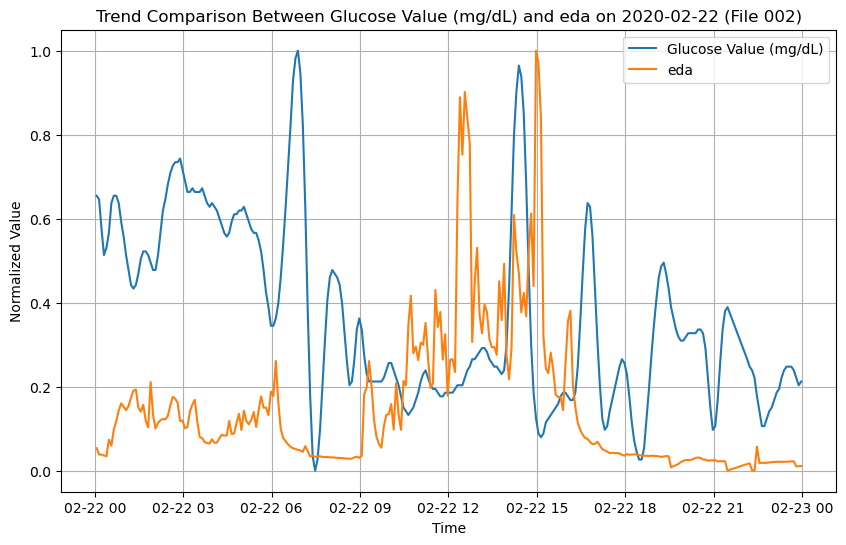

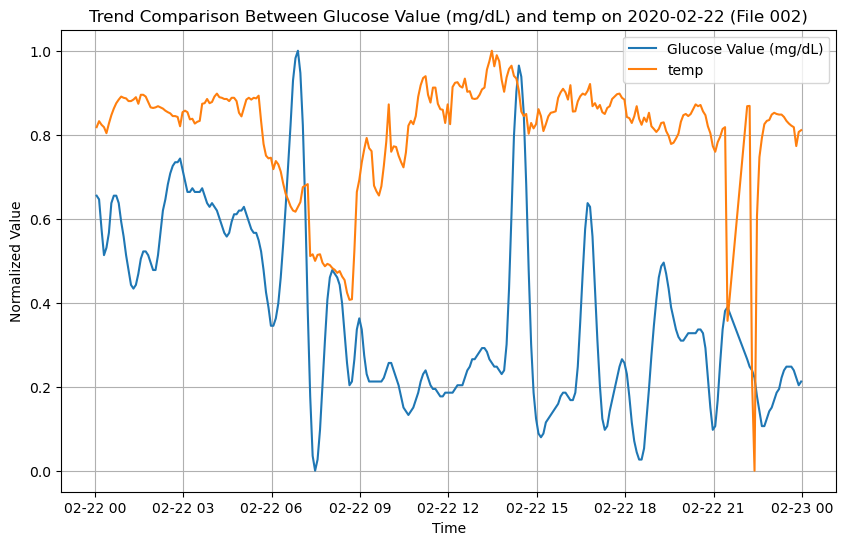

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 定义高糖阈值
gaotang = 140

# 指定要绘制的文件编号
file_num = '002'

# 指定要绘制的一天
target_date = '2020-02-22'

# 读取 CSV 文件
data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')

# 将第一列转换为 datetime 类型
data['datetime'] = pd.to_datetime(data.iloc[:, 0], errors='coerce')

# 过滤出目标日期的数据
day_data = data[data['datetime'].dt.date == pd.to_datetime(target_date).date()]

# 获取第二列（假设是数值类型）
second_column = day_data.columns[1]

# 检查第二列是否为数值类型
if not pd.api.types.is_numeric_dtype(day_data[second_column]):
    raise ValueError(f"The second column '{second_column}' is not numeric.")

# 对每一列进行归一化处理
for column in day_data.select_dtypes(include=['number']).columns:
    min_val = day_data[column].min()
    max_val = day_data[column].max()
    if max_val != min_val:  # 避免除以0的情况
        day_data[column] = (day_data[column] - min_val) / (max_val - min_val)
    else:
        # 如果最大值等于最小值，意味着该列所有的值都是相同的，可以设置为0或1
        day_data[column] = 0  # 或者选择其他合适的值

# 获取所有非时间列
feature_columns = day_data.columns[1:8]

# 对于每一个特征列创建一个新的图形
for i, col in enumerate(feature_columns):
    if col != second_column and pd.api.types.is_numeric_dtype(day_data[col]):
        plt.figure(figsize=(10, 6))
        plt.plot(day_data['datetime'], day_data[second_column], label=second_column)
        plt.plot(day_data['datetime'], day_data[col], label=col)
        
        plt.title(f'Trend Comparison Between {second_column} and {col} on {target_date} (File {file_num})')
        plt.xlabel('Time')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.grid(True)
        
        # 显示图形
        plt.show()

我们抽样002样本的其中一天，其各个特征与血糖值的时序图。试图找出不同特征的时序特征与血糖的时序特征的关系
- 关于acc，其有明显的白天高，夜晚低的趋势。且波动较大。这是由于白天活动较多，晚上活动较少。思路：可以检测运动，如果是有氧运动则血糖应该有下降趋势，如果是无氧运动应该血糖会有上升趋势
- 关于bvp，由图，bvp即血容量在一天中十分稳定，只有在部分时间出现了剧烈波动，与其对应的是血糖最低点。猜测bvp的波动与血糖过低有关，或者仅仅只是异常值，可以通过其他数据验证。
- 关于eda，eda为皮肤电刺激信号，通常与人的压力水平有关。而压力高导致的皮质醇浓度升高会导致血糖升高。由图中可以看出，其与血糖有一定的同峰情况，可以检测eda的高低来辅助推断血糖高低。
- 关于temp,对于002样本，在早上和入睡时降低明显。但可能是个人体质不一，需要验证。
- 关于hr和ibi,整体呈负相关，hr在白天高，晚上较低，ibi则相反。

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 定义高糖阈值
gaotang = 140

# 生成从 '002' 到 '016' 的文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 窗口大小设置为1小时
window_size = 12  # 1小时，12个数据点

# 步长设置为5分钟
step = 1  # 5分钟，1个数据点

# 需要统计的列名列表
columns_of_interest = ['acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp', 'ibi','hr']

# 需要累加的列名列表
cumulative_columns = ['calorie', 'total_carb', 'sugar', 'protein']

# 假设采样率为1个数据点/分钟
sampling_rate = 1  # 单位为数据点/分钟

for file_num in file_nums:
    # 读取 CSV 文件
    data = pd.read_csv(f'processed_data/processed_data_{file_num}.csv')
    
    # 立即统一列名格式
    data.columns = data.columns.str.strip().str.replace(' ', '_')
    
    # 将第一列转换为 datetime 类型
    data['datetime'] = pd.to_datetime(data.iloc[:, 0])
    
    # 如果整个文件的数据不足一个窗口大小，则跳过该文件
    if len(data) < window_size:
        print(f"File {file_num}: Insufficient data for sliding window.")
        continue
    
    # 初始化特征列表
    features = []
    
    # 滑动窗口统计特征
    for i in range(0, len(data) - window_size + 1, step):
        window = data.iloc[i:i + window_size]
        
        # 统一窗口内的列名格式
        window.columns = window.columns.str.strip().str.replace(' ', '_')
        
        # 计算血糖值 >= 140 的频数
        glucose_freq = (window['Glucose_Value_(mg/dL)'] >= gaotang).sum()
        
        # 计算其他列的统计量
        stats = {}
        for col in columns_of_interest:
            stats[col] = {
                'mean': window[col].mean(),
                'std': window[col].std(),
                'max': window[col].max(),
                'min': window[col].min(),
                'delta': window[col].iloc[-1] - window[col].iloc[0]
            }
            
            # 计算频谱特征
            freqs, psd = welch(window[col], fs=sampling_rate, nperseg=len(window)//2)
            stats[col]['peak_freq'] = freqs[psd > np.percentile(psd, 90)].tolist()  # 找到前10%的峰值频率
        
        # 计算累积列的和
        cumulative_sum = {}
        for col in cumulative_columns:
            cumulative_sum[col] = window[col].sum()
        
        # 添加滑动窗口结束位置的时间戳
        end_time = window['datetime'].iloc[-1]
        
        # 展开嵌套字典
        flattened_stats = {'glucose_freq': glucose_freq, 'end_time': end_time}
        for col in columns_of_interest:
            for key in stats[col]:
                flattened_stats[f"{col}_{key}"] = stats[col][key]
        
        # 添加累积列的和
        for col in cumulative_columns:
            flattened_stats[f"{col}_sum"] = cumulative_sum[col]
        
        features.append(flattened_stats)
    
    # 转换为DataFrame
    window_features = pd.DataFrame(features)
    
    # 保存到文件
    window_features.to_csv(f'window_data/sliding_window_features_{file_num}.csv', index=False)

    print(f"File {file_num}: Sliding window feature extraction completed with end timestamps and cumulative sums.")

File 002: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 003: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 004: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 005: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 006: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 007: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 008: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 009: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 010: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 011: Sliding window feature extraction completed with end timestamps and cumulative sums.
File 012: Sliding window feature extraction comple

### 任务点2.2 特征相关性分析与可视化

通过观察不同特征的分布特点，统计特征之间的相关性系数，再进行可视化展示。
可以通过python中的matplotlib工具包和seaborn工具实现可视化。

In [27]:
import pandas as pd

# 生成从 '002' 到 '016' 的文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 定义一个函数来清理包含方括号的字符串
def remove_brackets(value):
    if isinstance(value, str):
        return value.replace('[', '').replace(']', '')
    return value

for file_num in file_nums:
    # 加载数据
    data = pd.read_csv(f'window_data/sliding_window_features_{file_num}.csv')
    
    # 应用 remove_brackets 函数处理 DataFrame 中的每个元素
    data = data.applymap(remove_brackets)
    
    # 保存修改后的数据回到原文件
    data.to_csv(f'window_data/sliding_window_features_{file_num}.csv', index=False)

C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3090928809.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(remove_brackets)
C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3090928809.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(remove_brackets)
C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3090928809.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(remove_brackets)
C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3090928809.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(remove_brackets)
C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\3090928809.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(remove_brackets)
C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\

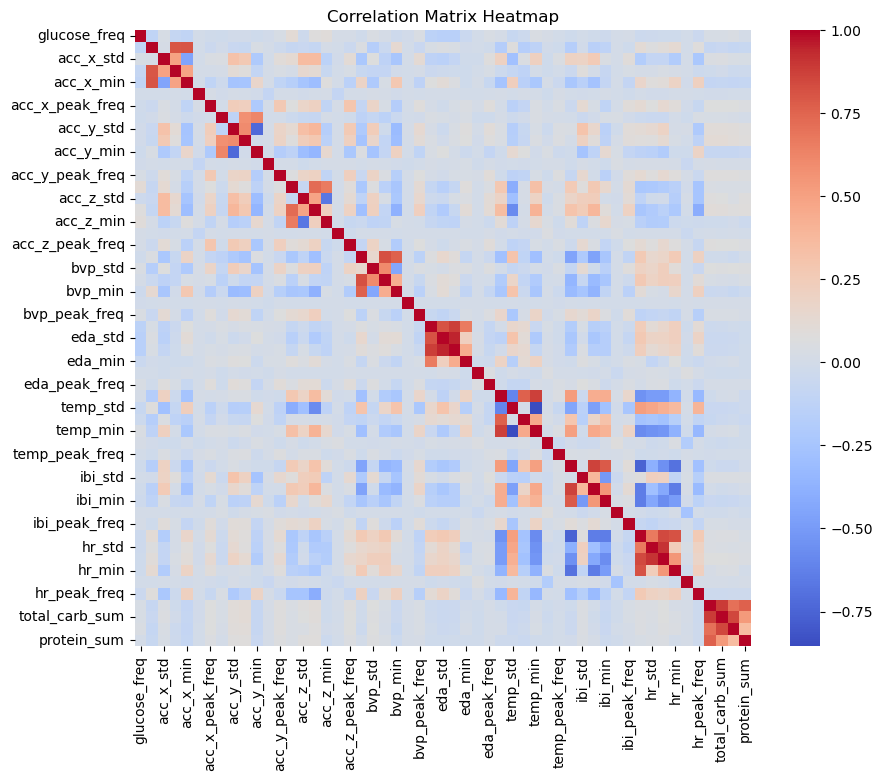

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成从 '002' 到 '016' 的文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的 DataFrame 用于存储所有文件的数据
all_data = pd.DataFrame()

for file_num in file_nums:
    # 加载数据
    data = pd.read_csv(f'window_data/sliding_window_features_{file_num}.csv')
    
    # 选择除了第二列（假设是 'end_time'）之外的所有列
    # 假设第二列是 'end_time'
    selected_columns = [col for col in data.columns if col != 'end_time']
    data_selected = data[selected_columns]
    
    # 将当前文件的数据追加到 all_data 中
    all_data = pd.concat([all_data, data_selected])

# 计算相关系数矩阵
correlation_matrix = all_data.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### 任务点2.3 特征工程

根据任务2.2对特征相关性与判别性的分析，汇总对目标任务有用的特征进行建模；将所有有用属性提取的特征拼接在一起，形成一个完整的样本矩阵，每一行表示一个阶段的观测数据（样本），每一列表示提取的一个特征值。
另外，针对某个时间段的高糖预测，可多采集前一个小时的观测数据，和当前时间段的数据一起作为样本的时序特征，以预测对发生高糖的可能性。

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存储所有数据
data_all = pd.DataFrame()

for file_num in file_nums:
    # 加载数据
    data = pd.read_csv(f'window_data/sliding_window_features_{file_num}.csv')
    data.columns = data.columns.str.strip()  
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择目标变量
# data_all['glucose_freq'] = np.where(data_all['glucose_freq'] > 0, 1, 0)
data_all = data_all.dropna()
target = data_all['glucose_freq']

# 选择特征，移除目标变量和无关特征
features = data_all.drop(columns=['end_time', 'glucose_freq'])

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 使用 SelectKBest 挑选最好的特征
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(features_scaled, target)

# 获取特征分数
feature_scores = selector.scores_

# 特征名和对应分数
feature_scores_df = pd.DataFrame({'Feature': features.columns, 'Score': feature_scores})

# 按分数排序并选择前5个最好的特征
best_features = feature_scores_df.sort_values(by='Score', ascending=False)
selected_features = best_features['Feature'].head(6)
print("All Files Combined")
print(best_features.head(6))  # 显示前6个最好的特征




All Files Combined
       Feature      Score
25     eda_std  62.928055
26     eda_max  60.871648
24    eda_mean  44.047621
3    acc_x_min  41.776213
50   sugar_sum  36.973946
12  acc_z_mean  36.168494


In [30]:
import pandas as pd
import os

# 定义最佳特征列表
best_features = ['eda_max', 'eda_std', 'eda_mean', 'sugar_sum', 'acc_x_min', 'acc_z_mean']

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 创建结果文件夹（如果不存在）
result_folder = 'final_data'
os.makedirs(result_folder, exist_ok=True)

# 对每个文件编号进行处理
for file_num in file_nums:
    # 加载数据
    input_path = f'window_data/sliding_window_features_{file_num}.csv'
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        continue
    
    data = pd.read_csv(input_path)
    
    # 选择最佳特征
    # 假设数据中包含以下列： 'datetime', 'glucose_freq', 以及 best_features 列
    selected_data = data[['end_time', 'glucose_freq'] + best_features]
    
    # 保存处理后的数据到结果文件夹
    output_path = os.path.join(result_folder, f'{file_num}.csv')
    selected_data.to_csv(output_path, index=False)
    
    print(f"Processed data has been saved to {output_path}")

Processed data has been saved to final_data\002.csv
Processed data has been saved to final_data\003.csv
Processed data has been saved to final_data\004.csv
Processed data has been saved to final_data\005.csv
Processed data has been saved to final_data\006.csv
Processed data has been saved to final_data\007.csv
Processed data has been saved to final_data\008.csv
Processed data has been saved to final_data\009.csv
Processed data has been saved to final_data\010.csv
Processed data has been saved to final_data\011.csv
Processed data has been saved to final_data\012.csv
Processed data has been saved to final_data\013.csv
Processed data has been saved to final_data\014.csv
Processed data has been saved to final_data\015.csv
Processed data has been saved to final_data\016.csv


In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 对每个文件编号进行处理
for file_num in file_nums:
    # 加载数据
    input_path = os.path.join('final_data', f'{file_num}.csv')
    if not os.path.exists(input_path):
        print(f"File not found: {input_path}")
        continue
    
    data = pd.read_csv(input_path)
    
    # 检查是否存在 end_time 列
    if 'end_time' in data.columns:
        # 将 end_time 列转换为 Unix 时间戳
        data['end_time'] = pd.to_datetime(data['end_time'], format='%Y-%m-%d %H:%M:%S').astype('int64') // 10**9
        
        # 如果 end_time 存在，则将其移动到第二列
        cols = data.columns.tolist()
        cols.insert(1, cols.pop(cols.index('end_time')))
        data = data.loc[:, cols]
        data.drop(columns=['end_time'], inplace=True)
        
    # 选择需要标准化的列
    columns_to_standardize = data.columns[1:]  # 从第二列开始
    
    # 初始化 StandardScaler
    scaler = StandardScaler()
    
    # 对需要标准化的列进行标准化处理
    data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])
    
    # 保存处理后的数据到结果文件夹
    result_folder = 'final_data'
    output_path = os.path.join(result_folder, f'{file_num}.csv')
    data.to_csv(output_path, index=False)
    
    print(f"Standardized data has been saved to {output_path}")

Standardized data has been saved to final_data\002.csv
Standardized data has been saved to final_data\003.csv
Standardized data has been saved to final_data\004.csv
Standardized data has been saved to final_data\005.csv
Standardized data has been saved to final_data\006.csv
Standardized data has been saved to final_data\007.csv
Standardized data has been saved to final_data\008.csv
Standardized data has been saved to final_data\009.csv
Standardized data has been saved to final_data\010.csv
Standardized data has been saved to final_data\011.csv
Standardized data has been saved to final_data\012.csv
Standardized data has been saved to final_data\013.csv
Standardized data has been saved to final_data\014.csv
Standardized data has been saved to final_data\015.csv
Standardized data has been saved to final_data\016.csv


### 任务点3.1 训练集与测试集划分
请完成训练集与测试集划分任务，具体划分要求为同一人的数据不能同时作为训练集和测试集。一共16位用户的数据可以参考4:1或3:2的方式进行划分。
考虑到发生高糖的次数非常少，会造成高糖标记样本远少于低糖标记样本的类别不平衡问题，可通过降采样、过采样SMOTE等方法进行处理。

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放训练集和测试集数据
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'final_data/{file_num}.csv')
    
    # 将数据追加到相应的DataFrame
    if file_num in ['009', '011']:
        test_data = pd.concat([test_data, data], ignore_index=True)
    else:
        train_data = pd.concat([train_data, data], ignore_index=True)

# 获取第一列的名字
first_column_name = train_data.columns[0]

# 将第一列转换为目标变量二分类，如果>0则标记为1，否则为0
train_data[first_column_name] = (train_data[first_column_name] > 0).astype(int)
test_data[first_column_name] = (test_data[first_column_name] > 0).astype(int)

# 分离特征和目标变量
X_train = train_data.drop(first_column_name, axis=1)
y_train = train_data[first_column_name]

X_test = test_data.drop(first_column_name, axis=1)
y_test = test_data[first_column_name]

# 创建SMOTE实例
sm = SMOTE(sampling_strategy={1: len(y_train[y_train == 0])}, random_state=42)
# 对训练集进行过采样
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# 合并过采样后的特征和目标变量
train_resampled = pd.concat([X_train_res, y_train_res], axis=1)

# 查看过采样后的前几行数据
print(train_resampled.head())

# 保存处理后的训练集和测试集
train_resampled.to_csv('train_test_data_binary/train_resampled.csv', index=False)
X_test.to_csv('train_test_data_binary/X_test.csv', index=False)
y_test.to_csv('train_test_data_binary/y_test.csv', index=False)

print("Train and test sets have been processed and saved.")

    eda_max   eda_std  eda_mean  sugar_sum  acc_x_min  acc_z_mean  \
0 -0.544867 -0.485389 -0.514385  -0.450338   0.488968    1.091837   
1 -0.553896 -0.483379 -0.519125   0.900017  -0.218853    0.812283   
2 -0.554717 -0.482878 -0.521699   0.900017  -0.218853    0.547707   
3 -0.554717 -0.480062 -0.524683   0.900017  -0.218853    0.258676   
4 -0.554717 -0.472443 -0.529481   0.900017  -0.218853    0.116224   

   glucose_freq  
0             1  
1             1  
2             1  
3             1  
4             1  
Train and test sets have been processed and saved.


### 任务点3.2 模型构建与参数调优

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    make_scorer
)
from tqdm import tqdm

# 读取训练集和测试集
X_train = pd.read_csv('train_test_data_binary/train_resampled.csv').drop('glucose_freq', axis=1)
y_train = pd.read_csv('train_test_data_binary/train_resampled.csv')['glucose_freq']
X_test = pd.read_csv('train_test_data_binary/X_test.csv')
y_test = pd.read_csv('train_test_data_binary/y_test.csv')['glucose_freq']

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义分类器和参数网格
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'C': [0.001, 0.01], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    'Support Vector Machine': {
        'model': SVC(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
    }
}

# 定义评估指标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# 交叉验证和网格搜索
for name, classifier_info in tqdm(classifiers.items(), desc="Classifiers"):
    model = classifier_info['model']
    params = classifier_info['params']
    
    # 创建GridSearchCV实例
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,  # 5折交叉验证
        scoring=scoring,  # 使用多个评估指标
        refit='recall'  # 选择最佳模型时使用召回率
    )
    
    # 拟合模型
    grid_search.fit(X_train_scaled, y_train)
    
    # 获取最佳模型和参数
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # 评估最佳模型
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # 输出结果
    print(f"Classifier: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}\n")

Classifiers:  33%|███▎      | 1/3 [00:00<00:01,  1.85it/s]

Classifier: Logistic Regression
Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.4992
Recall: 0.6331
Precision: 0.3582
F1 Score: 0.4576
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.43      0.53      2814
           1       0.36      0.63      0.46      1409

    accuracy                           0.50      4223
   macro avg       0.53      0.53      0.50      4223
weighted avg       0.59      0.50      0.51      4223




Classifiers:  67%|██████▋   | 2/3 [13:06<07:42, 462.47s/it]

Classifier: Support Vector Machine
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.4625
Recall: 0.7282
Precision: 0.3522
F1 Score: 0.4748
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.33      0.45      2814
           1       0.35      0.73      0.47      1409

    accuracy                           0.46      4223
   macro avg       0.53      0.53      0.46      4223
weighted avg       0.59      0.46      0.46      4223




Classifiers: 100%|██████████| 3/3 [16:21<00:00, 327.18s/it]

Classifier: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.5475
Recall: 0.5422
Precision: 0.3764
F1 Score: 0.4443
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      2814
           1       0.38      0.54      0.44      1409

    accuracy                           0.55      4223
   macro avg       0.54      0.55      0.53      4223
weighted avg       0.60      0.55      0.56      4223




In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    make_scorer
)
from tqdm import tqdm

# 读取训练集和测试集
X_train = pd.read_csv('train_test_data_binary/train_resampled.csv').drop('glucose_freq', axis=1)
y_train = pd.read_csv('train_test_data_binary/train_resampled.csv')['glucose_freq']
X_test = pd.read_csv('train_test_data_binary/X_test.csv')
y_test = pd.read_csv('train_test_data_binary/y_test.csv')['glucose_freq']

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义分类器和参数网格
classifiers = {
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    }
}

# 定义评估指标
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# 交叉验证和网格搜索
for name, classifier_info in tqdm(classifiers.items(), desc="Classifiers"):
    model = classifier_info['model']
    params = classifier_info['params']
    
    # 创建GridSearchCV实例
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,  # 5折交叉验证
        scoring=scoring,  # 使用多个评估指标
        refit='recall'  # 选择最佳模型时使用召回率
    )
    
    # 拟合模型
    grid_search.fit(X_train_scaled, y_train)
    
    # 获取最佳模型和参数
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # 评估最佳模型
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # 输出结果
    print(f"Classifier: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Classification Report:\n{report}\n")

Classifiers:  50%|█████     | 1/2 [03:09<03:09, 189.44s/it]

Classifier: Gradient Boosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.4430
Recall: 0.6714
Precision: 0.3337
F1 Score: 0.4458
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44      2814
           1       0.33      0.67      0.45      1409

    accuracy                           0.44      4223
   macro avg       0.50      0.50      0.44      4223
weighted avg       0.56      0.44      0.44      4223




C:\Users\aimer\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [23:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\aimer\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [23:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\aimer\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [23:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

Classifier: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.4449
Recall: 0.7048
Precision: 0.3400
F1 Score: 0.4587
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.31      0.43      2814
           1       0.34      0.70      0.46      1409

    accuracy                           0.44      4223
   macro avg       0.51      0.51      0.44      4223
weighted avg       0.57      0.44      0.44      4223




### 任务点4.1 构造新的训练集与测试集

从现有训练集中选取所有出现高糖的时间段，将该时间段的观测序列与血糖值序列构成新的训练集；测试集是从原有测试集中找出所有任务3预测为高糖的时间段的数据。可以看出，任务3的结果影响任务4的测试集，因而任务3主要是把出现高糖的时间段尽可能多地筛选出来，更注重召回率。

In [35]:
import pandas as pd

def aggregate_data(df):
    # 设定时间窗口为每小时
    df.set_index('datetime', inplace=True)
    
    # 处理重复的时间戳
    df = df[~df.index.duplicated(keep='first')]
    
    # 聚合非营养数据：计算平均值、方差
    agg_functions = {
        'acc_x': ['mean', 'var'],
        'acc_y': ['mean', 'var'],
        'acc_z': ['mean', 'var'],
        'bvp': ['mean', 'var'],
        'eda': ['mean', 'var'],
        'temp': ['mean', 'var'],
        'hr': ['mean', 'var'],
        'ibi': ['mean', 'var'],
        'elevated_hr_past_hour': ['mean', 'var']
    }
    
    # 累积营养数据
    nutrition_columns = ['calorie', 'total_carb', 'sugar', 'protein']
    df[nutrition_columns] = df[nutrition_columns].cumsum()
    
    # 计算 Glucose Value (mg/dL) 每小时内大于等于140的次数
    # 先按小时进行重采样
    hourly_df = df.resample('h').agg({
        'Glucose Value (mg/dL)': lambda x: (x >= 140).sum(),
        **{col: 'sum' for col in nutrition_columns}
    })
    
    # 重命名列
    hourly_df.rename(columns={'Glucose Value (mg/dL)': 'Glucose Condition Count'}, inplace=True)
    
    # 聚合数据
    hourly_data = df.resample('h').agg(agg_functions)
    
    # 添加营养数据
    for col in nutrition_columns:
        hourly_data[col] = hourly_df[col]
    
    # 添加 Glucose Condition Count 列
    hourly_data['Glucose Condition Count'] = hourly_df['Glucose Condition Count']
    
    # 重置索引以便将时间列放回 DataFrame 中
    hourly_data.reset_index(inplace=True)
    
    # 添加小时列
    hourly_data['hour'] = hourly_data['datetime'].dt.hour
    
    # 将多级索引转换为单级索引，并确保列名唯一
    hourly_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in hourly_data.columns.values]
    
    # 添加增量列
    for col, functions in agg_functions.items():
        for func in functions:
            if func == 'mean':
                # 使用多级索引访问特定列
                mean_col_name = f'{col} mean'
                if mean_col_name in hourly_data.columns:
                    hourly_data[f'{col} Increment'] = hourly_data[mean_col_name].diff()
    # 补充开头的缺失值，向上补全
    hourly_data.ffill()
    
    return hourly_data

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 主循环
for file_num in file_nums:
    # 加载处理过的数据
    data_with_nutrition = pd.read_csv(f'processed_data1/nutrition/processed_data_{file_num}_nutrition.csv')
    # 将 datetime 列转换为 datetime 对象
    data_with_nutrition['datetime'] = pd.to_datetime(data_with_nutrition['datetime'])
    
    # 聚合数据
    hourly_aggregated_data = aggregate_data(data_with_nutrition)
    
    # 删除包含 NaN 值的行
    hourly_aggregated_data.dropna(inplace=True)
    
    # 保存处理后的数据
    hourly_aggregated_data.to_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv', index=False)
    
    print(f'processed_data_{file_num}_hourly.csv saved')

processed_data_002_hourly.csv saved
processed_data_003_hourly.csv saved
processed_data_004_hourly.csv saved
processed_data_005_hourly.csv saved
processed_data_006_hourly.csv saved
processed_data_007_hourly.csv saved
processed_data_008_hourly.csv saved
processed_data_009_hourly.csv saved
processed_data_010_hourly.csv saved
processed_data_011_hourly.csv saved
processed_data_012_hourly.csv saved
processed_data_013_hourly.csv saved
processed_data_014_hourly.csv saved
processed_data_015_hourly.csv saved
processed_data_016_hourly.csv saved


C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\4250160747.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nutrition_columns] = df[nutrition_columns].cumsum()


In [36]:
# 请在下方完成任务
# 从原本的二分类问题变成回归问题，需要预测出具体的高糖次数
# 具体次数在processed_data1/hourly/processed_data_{file_num}_hourly.csv中的Glucose Condition Count列中


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean','hour']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
data_all[y_column_name].fillna(0)
y = data_all[y_column_name]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 合并过采样后的特征和目标变量
train_resampled = pd.DataFrame(X_train_scaled, columns=selected_features)
train_resampled[y_column_name] = y_train

# 查看过采样后的前几行数据
print(train_resampled.head())

# 保存处理后的训练集和测试集
train_resampled.to_csv('train_test_data_food/train_resampled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=selected_features).to_csv('train_test_data_food/X_test.csv', index=False)
y_test.to_csv('train_test_data_food/y_test.csv', index=False)

print("Train and test sets have been processed and saved.")

      sugar  total_carb   calorie   protein  eda mean  acc_x mean      hour  \
0 -0.840449   -1.007571 -0.999976 -0.920498  0.284381    0.261893 -0.508527   
1  2.425102    2.490811  2.660813  2.373818 -0.295547   -0.074690 -1.387791   
2 -0.752982   -0.702050 -0.813391 -0.798580  0.456923    1.359779 -0.655071   
3 -0.408833   -0.164873 -0.371195 -0.304758 -0.469279   -0.227058 -1.387791   
4  2.465093    1.953941  1.121864  0.283849 -0.333745   -1.348539  0.956913   

   Glucose Condition Count  
0                      2.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                     10.0  
Train and test sets have been processed and saved.


### 任务点4.2 细粒度高糖预测模型构建与参数调优

可以运用HMM、LSTM等一种时序预测算法，构建一个时间段的高糖时序预测模型，并进行调参；也可以对该时间段内的高糖次数进行回归分析，构建高糖预测回归模型，并进行调参。

Linear Regression: Mean Squared Error=8.2344, R^2 Score=0.0464
Support Vector Regression: Mean Squared Error=9.4818, R^2 Score=-0.0981
Random Forest Regression: Mean Squared Error=7.0494, R^2 Score=0.1836
Gradient Boosting Regression: Mean Squared Error=7.4915, R^2 Score=0.1324
Model Linear Regression has been saved.
Model Support Vector Regression has been saved.
Model Random Forest Regression has been saved.
Model Gradient Boosting Regression has been saved.


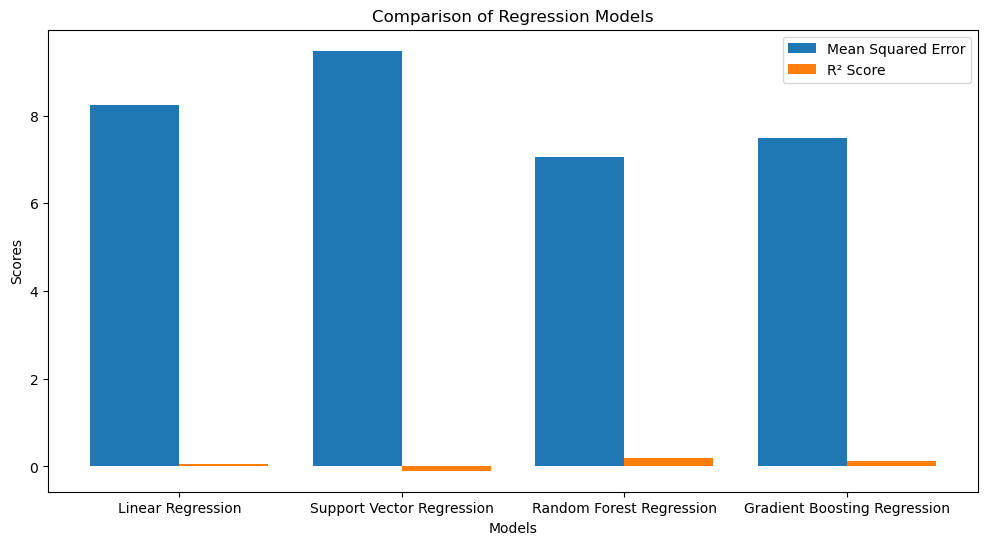

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/hourly/processed_data_{file_num}_hourly.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean', 'hour']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
y = data_all[y_column_name].fillna(0)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化模型列表
models = [
    ('Linear Regression', LinearRegression()),
    ('Support Vector Regression', SVR(kernel='rbf')),
    ('Random Forest Regression', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regression', GradientBoostingRegressor(random_state=42))
]

# 定义参数网格
param_grids = {
    'Support Vector Regression': {'C': [1, 10], 'gamma': ['scale', 'auto']},
    'Random Forest Regression': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'Gradient Boosting Regression': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}
}

# 存储结果
results = []

# 训练并评估每个模型
for name, model in models:
    if name in param_grids:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, r2))

    print(f"{name}: Mean Squared Error={mse:.4f}, R^2 Score={r2:.4f}")

# 保存模型
for name, model in models:
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')
    print(f"Model {name} has been saved.")

# 可视化结果
names, mse_scores, r2_scores = zip(*results)
indexes = np.arange(len(names))

plt.figure(figsize=(12, 6))
plt.bar(indexes - 0.2, mse_scores, width=0.4, label='Mean Squared Error')
plt.bar(indexes + 0.2, r2_scores, width=0.4, label='R² Score')
plt.xticks(indexes, names)
plt.legend()
plt.title('Comparison of Regression Models')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.show()

### 任务点4.3 模型预测与高糖结果统计

运用所训练的细粒度高糖预测模型预测测试集中每个阶段的高糖变化，并计算测试集中每个用户一天发生高糖的次数，与真实值比较，计算误差RMSE和R2分数；

In [39]:
import pandas as pd

def aggregate_data_daily(df):
    # 设定时间窗口为每天
    df.set_index('datetime', inplace=True)
    
    # 处理重复的时间戳
    df = df[~df.index.duplicated(keep='first')]
    
    # 聚合非营养数据：计算平均值、方差
    agg_functions = {
        'acc_x': ['mean', 'var'],
        'acc_y': ['mean', 'var'],
        'acc_z': ['mean', 'var'],
        'bvp': ['mean', 'var'],
        'eda': ['mean', 'var'],
        'temp': ['mean', 'var'],
        'hr': ['mean', 'var'],
        'ibi': ['mean', 'var'],
        'elevated_hr_past_hour': ['mean', 'var']
    }
    
    # 累积营养数据
    nutrition_columns = ['calorie', 'total_carb', 'sugar', 'protein']
    df[nutrition_columns] = df[nutrition_columns].cumsum()
    
    # 计算 Glucose Value (mg/dL) 每天内大于等于140的次数
    # 先按天进行重采样
    daily_df = df.resample('D').agg({
        'Glucose Value (mg/dL)': lambda x: (x >= 140).sum(),
        **{col: 'sum' for col in nutrition_columns}
    })
    
    # 重命名列
    daily_df.rename(columns={'Glucose Value (mg/dL)': 'Glucose Condition Count'}, inplace=True)
    
    # 聚合数据
    daily_data = df.resample('D').agg(agg_functions)
    
    # 添加营养数据
    for col in nutrition_columns:
        daily_data[col] = daily_df[col]
    
    # 添加 Glucose Condition Count 列
    daily_data['Glucose Condition Count'] = daily_df['Glucose Condition Count']
    
    # 重置索引以便将时间列放回 DataFrame 中
    daily_data.reset_index(inplace=True)
    
    # 添加天数列
    daily_data['day'] = daily_data['datetime'].dt.day
    
    # 将多级索引转换为单级索引，并确保列名唯一
    daily_data.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in daily_data.columns.values]
    
    # 添加增量列
    for col, functions in agg_functions.items():
        for func in functions:
            if func == 'mean':
                # 使用多级索引访问特定列
                mean_col_name = f'{col} mean'
                if mean_col_name in daily_data.columns:
                    daily_data[f'{col} Increment'] = daily_data[mean_col_name].diff()
    # 补充开头的缺失值，向上补全
    daily_data.ffill(inplace=True)
    
    return daily_data

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 主循环
for file_num in file_nums:
    # 加载处理过的数据
    data_with_nutrition = pd.read_csv(f'processed_data1/nutrition/processed_data_{file_num}_nutrition.csv')
    # 将 datetime 列转换为 datetime 对象
    data_with_nutrition['datetime'] = pd.to_datetime(data_with_nutrition['datetime'])
    
    # 聚合数据
    daily_aggregated_data = aggregate_data_daily(data_with_nutrition)
    
    # 删除包含 NaN 值的行
    daily_aggregated_data.dropna(inplace=True)
    
    # 保存处理后的数据
    daily_aggregated_data.to_csv(f'processed_data1/daily/processed_data_{file_num}_daily.csv', index=False)
    
    print(f'processed_data_{file_num}_daily.csv saved')

processed_data_002_daily.csv saved
processed_data_003_daily.csv saved
processed_data_004_daily.csv saved
processed_data_005_daily.csv saved
processed_data_006_daily.csv saved
processed_data_007_daily.csv saved
processed_data_008_daily.csv saved
processed_data_009_daily.csv saved
processed_data_010_daily.csv saved
processed_data_011_daily.csv saved
processed_data_012_daily.csv saved
processed_data_013_daily.csv saved
processed_data_014_daily.csv saved
processed_data_015_daily.csv saved
processed_data_016_daily.csv saved


C:\Users\aimer\AppData\Local\Temp\ipykernel_23896\1911834497.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nutrition_columns] = df[nutrition_columns].cumsum()


In [40]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 生成文件编号
file_nums = [f'{i:03d}' for i in range(2, 17)]

# 初始化一个空的DataFrame用于存放所有数据
data_all = pd.DataFrame()

# 对每个文件编号进行处理
for file_num in file_nums:
    # 读取文件
    data = pd.read_csv(f'processed_data1/daily/processed_data_{file_num}_daily.csv')
    # 将数据追加到data_all
    data_all = pd.concat([data_all, data], ignore_index=True)

# 选择特征列
selected_features = ['sugar', 'total_carb', 'calorie', 'protein', 'eda mean', 'acc_x mean']
y_column_name = 'Glucose Condition Count'
X = data_all[selected_features]
data_all[y_column_name].fillna(0)

y = data_all[y_column_name]
print(y)
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train)
# 标准化训练集和测试集
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 合并过采样后的特征和目标变量
train_resampled = pd.DataFrame(X_train_scaled, columns=selected_features)
train_resampled[y_column_name] = y_train

# 查看过采样后的前几行数据
print(train_resampled.head())

# 保存处理后的训练集和测试集
train_resampled.to_csv('train_test_data_day/train_resampled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=selected_features).to_csv('train_test_data_food/X_test.csv', index=False)
y_test.to_csv('train_test_data_day/y_test.csv', index=False)

print("Train and test sets have been processed and saved.")

0       83
1      108
2       70
3        5
4       52
      ... 
116      2
117      8
118     17
119     16
120     27
Name: Glucose Condition Count, Length: 121, dtype: int64
12      9
15      8
115    21
76     59
98     81
       ..
106    85
14      5
92     23
51      0
102    22
Name: Glucose Condition Count, Length: 96, dtype: int64
      sugar  total_carb   calorie   protein  eda mean  acc_x mean  \
0 -0.929193   -0.633335 -0.928076 -1.037653  0.973228   -1.418392   
1 -0.929193   -0.789156 -1.012085 -1.037653 -0.649889   -0.035150   
2 -0.929193   -1.173146 -1.169824 -1.037653 -0.051783    0.986984   
3 -0.068230   -0.357512 -0.660531 -0.763961  0.324275   -0.829472   
4  1.459040    1.585195  1.938092  2.435242 -0.041635   -0.097710   

   Glucose Condition Count  
0                      NaN  
1                    108.0  
2                     70.0  
3                      5.0  
4                      NaN  
Train and test sets have been processed and saved.


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 定义模型
model = RandomForestRegressor()

# 定义参数网格
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # 树的数量
    'max_depth': [10, 20, 30, None],        # 树的最大深度
    'min_samples_split': [2, 5, 10, 20],    # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4, 10]       # 叶子节点所需的最小样本数
}

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 拟合模型
grid_search.fit(X_train_scaled, y_train)

# 获取最佳参数
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# 使用最佳参数训练模型
best_model = grid_search.best_estimator_

# 预测
y_pred = best_model.predict(X_test_scaled)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 200}
Mean Squared Error: 541.6034449636104
R^2 Score: 0.015191976404741903
